### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_1/'
summaries_path = cur_dir + 'summaries_2_1/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 1
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.5], average train loss: 1.198510, average train accuracy: 0.618164
epoch: 2, iter: 0/8, validation accuracies: [0.5], average train loss: 0.899699, average train accuracy: 0.658203
epoch: 3, iter: 0/8, validation accuracies: [0.57499999], average train loss: 0.651313, average train accuracy: 0.659180
epoch: 4, iter: 0/8, validation accuracies: [0.875], average train loss: 0.644754, average train accuracy: 0.687500
epoch: 5, iter: 0/8, validation accuracies: [0.60000002], average train loss: 0.521506, average train accuracy: 0.739258
epoch: 6, iter: 0/8, validation accuracies: [0.55000001], average train loss: 0.517296, average train accuracy: 0.746094
epoch: 7, iter: 0/8, validation accuracies: [0.80000001], average train loss: 0.519423, average train accuracy: 0.747070
epoch: 8, 

epoch: 66, iter: 0/8, validation accuracies: [0.875], average train loss: 0.162052, average train accuracy: 0.934570
epoch: 67, iter: 0/8, validation accuracies: [0.85000002], average train loss: 0.145465, average train accuracy: 0.934570
epoch: 68, iter: 0/8, validation accuracies: [0.875], average train loss: 0.147616, average train accuracy: 0.941406
epoch: 69, iter: 0/8, validation accuracies: [0.85000002], average train loss: 0.109240, average train accuracy: 0.958008
epoch: 70, iter: 0/8, validation accuracies: [0.875], average train loss: 0.148094, average train accuracy: 0.938477
epochs: 70.000000, final train loss: 0.176507, validation accuracies: [0.875]
best epochs: 24.000000, best_avg: 0.925000, validation accuracies: [0.92500001]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.39178991317749023
saving penultimate out

epoch: 49, iter: 0/8, validation accuracies: [0.625      0.94999999], average train loss: 0.440008, average train accuracy: 0.826172
epoch: 50, iter: 0/8, validation accuracies: [0.67500001 0.94999999], average train loss: 0.458581, average train accuracy: 0.823242
epoch: 50, iter: 0/8, loss: 0.545523, accuracy: 0.796875
epoch: 51, iter: 0/8, validation accuracies: [0.80000001 0.80000001], average train loss: 0.427628, average train accuracy: 0.844727
epoch: 52, iter: 0/8, validation accuracies: [0.72500002 0.89999998], average train loss: 0.408003, average train accuracy: 0.844727
epoch: 53, iter: 0/8, validation accuracies: [0.80000001 0.89999998], average train loss: 0.351577, average train accuracy: 0.874023
epoch: 54, iter: 0/8, validation accuracies: [0.82499999 0.80000001], average train loss: 0.417072, average train accuracy: 0.835938
epoch: 55, iter: 0/8, validation accuracies: [0.80000001 0.82499999], average train loss: 0.352996, average train accuracy: 0.869141
epoch: 56, i

epoch: 29, iter: 0/8, validation accuracies: [0.72500002 0.60000002 0.72500002], average train loss: 0.680244, average train accuracy: 0.752930
epoch: 30, iter: 0/8, validation accuracies: [0.80000001 0.64999998 0.625     ], average train loss: 0.730738, average train accuracy: 0.728516
epoch: 31, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.77499998], average train loss: 0.703976, average train accuracy: 0.738281
epoch: 32, iter: 0/8, validation accuracies: [0.75       0.44999999 0.69999999], average train loss: 0.658736, average train accuracy: 0.750977
epoch: 33, iter: 0/8, validation accuracies: [0.89999998 0.67500001 0.44999999], average train loss: 0.751197, average train accuracy: 0.719727
epoch: 34, iter: 0/8, validation accuracies: [0.52499998 0.82499999 0.55000001], average train loss: 0.722543, average train accuracy: 0.722656
epoch: 35, iter: 0/8, validation accuracies: [0.625      0.80000001 0.75      ], average train loss: 0.645170, average train accuracy: 0

epoch: 7, iter: 0/8, validation accuracies: [0.42500001 0.64999998 0.75       0.57499999], average train loss: 0.963778, average train accuracy: 0.644531
epoch: 8, iter: 0/8, validation accuracies: [0.5        0.64999998 0.57499999 0.77499998], average train loss: 0.937073, average train accuracy: 0.653320
epoch: 9, iter: 0/8, validation accuracies: [0.60000002 0.625      0.64999998 0.625     ], average train loss: 0.933602, average train accuracy: 0.683594
epoch: 10, iter: 0/8, validation accuracies: [0.27500001 0.67500001 0.75       0.47499999], average train loss: 0.815410, average train accuracy: 0.694336
epoch: 11, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.34999999 0.67500001], average train loss: 0.843947, average train accuracy: 0.729492
epoch: 12, iter: 0/8, validation accuracies: [0.30000001 0.67500001 0.625      0.55000001], average train loss: 0.823249, average train accuracy: 0.679688
epoch: 12, iter: 4/8, loss: 0.852725, accuracy: 0.703125
epoch: 13, iter:

epoch: 59, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.75       0.85000002], average train loss: 0.424170, average train accuracy: 0.871094
epoch: 60, iter: 0/8, validation accuracies: [0.625      0.75       0.77499998 0.89999998], average train loss: 0.426480, average train accuracy: 0.840820
epoch: 61, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.75       0.85000002], average train loss: 0.387931, average train accuracy: 0.860352
epoch: 62, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.77499998 0.82499999], average train loss: 0.397178, average train accuracy: 0.870117
epoch: 62, iter: 4/8, loss: 0.371677, accuracy: 0.890625
epoch: 63, iter: 0/8, validation accuracies: [0.75       0.67500001 0.75       0.82499999], average train loss: 0.427272, average train accuracy: 0.846680
epoch: 64, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.75       0.82499999], average train loss: 0.404739, average train accuracy: 0.858398
epoch: 65, it

epoch: 32, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.80000001 0.55000001 0.47499999], average train loss: 0.754274, average train accuracy: 0.693359
epoch: 33, iter: 0/8, validation accuracies: [0.40000001 0.92500001 0.625      0.5        0.55000001], average train loss: 0.810359, average train accuracy: 0.657227
epoch: 34, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.64999998 0.80000001 0.47499999], average train loss: 0.819475, average train accuracy: 0.667969
epoch: 35, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.64999998 0.85000002 0.57499999], average train loss: 0.705163, average train accuracy: 0.651367
epoch: 36, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.55000001 0.75       0.42500001], average train loss: 0.757314, average train accuracy: 0.693359
epoch: 37, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.69999999 0.80000001 0.52499998], average train loss: 0.795416, average train accuracy: 0.682617
epoc

epoch: 3, iter: 0/8, validation accuracies: [0.05       0.40000001 0.32499999 0.60000002 0.55000001 0.25      ], average train loss: 1.824994, average train accuracy: 0.290039
epoch: 4, iter: 0/8, validation accuracies: [0.32499999 0.44999999 0.42500001 0.67500001 0.34999999 0.5       ], average train loss: 1.639878, average train accuracy: 0.363281
epoch: 5, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.44999999 0.625      0.2        0.32499999], average train loss: 1.454858, average train accuracy: 0.370117
epoch: 6, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.42500001 0.34999999 0.60000002 0.67500001], average train loss: 1.474568, average train accuracy: 0.373047
epoch: 7, iter: 0/8, validation accuracies: [0.30000001 0.625      0.64999998 0.57499999 0.52499998 0.5       ], average train loss: 1.324897, average train accuracy: 0.505859
epoch: 8, iter: 0/8, validation accuracies: [0.375      0.30000001 0.72500002 0.55000001 0.42500001 0.40000001], average

epoch: 49, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.77499998 0.75       0.40000001 0.64999998], average train loss: 0.679112, average train accuracy: 0.781250
epoch: 50, iter: 0/8, validation accuracies: [0.67500001 0.75       0.75       0.80000001 0.55000001 0.72500002], average train loss: 0.721406, average train accuracy: 0.756836
epoch: 50, iter: 0/8, loss: 0.636952, accuracy: 0.796875
epoch: 51, iter: 0/8, validation accuracies: [0.75       0.80000001 0.72500002 0.82499999 0.55000001 0.67500001], average train loss: 0.658680, average train accuracy: 0.780273
epoch: 52, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.69999999 0.75       0.64999998 0.72500002], average train loss: 0.680428, average train accuracy: 0.769531
epoch: 53, iter: 0/8, validation accuracies: [0.69999999 0.72500002 0.72500002 0.75       0.67500001 0.72500002], average train loss: 0.580676, average train accuracy: 0.804688
epoch: 54, iter: 0/8, validation accuracies: [0.625      0

epoch: 17, iter: 0/8, validation accuracies: [0.375      0.77499998 0.60000002 0.625      0.40000001 0.72500002
 0.60000002], average train loss: 0.951442, average train accuracy: 0.679688
epoch: 18, iter: 0/8, validation accuracies: [0.5        0.77499998 0.69999999 0.55000001 0.57499999 0.42500001
 0.625     ], average train loss: 0.942710, average train accuracy: 0.635742
epoch: 19, iter: 0/8, validation accuracies: [0.34999999 0.77499998 0.57499999 0.30000001 0.42500001 0.64999998
 0.40000001], average train loss: 1.021490, average train accuracy: 0.643555
epoch: 20, iter: 0/8, validation accuracies: [0.40000001 0.47499999 0.375      0.60000002 0.5        0.64999998
 0.42500001], average train loss: 1.014848, average train accuracy: 0.638672
epoch: 21, iter: 0/8, validation accuracies: [0.42500001 0.55000001 0.42500001 0.42500001 0.67500001 0.82499999
 0.64999998], average train loss: 0.936524, average train accuracy: 0.681641
epoch: 22, iter: 0/8, validation accuracies: [0.4499999

epoch: 60, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.72500002 0.92500001 0.69999999 0.77499998
 0.82499999], average train loss: 0.542162, average train accuracy: 0.827148
epoch: 61, iter: 0/8, validation accuracies: [0.67500001 0.80000001 0.67500001 0.875      0.75       0.77499998
 0.80000001], average train loss: 0.592702, average train accuracy: 0.831055
epoch: 62, iter: 0/8, validation accuracies: [0.67500001 0.75       0.67500001 0.875      0.77499998 0.82499999
 0.77499998], average train loss: 0.572852, average train accuracy: 0.822266
epoch: 62, iter: 4/8, loss: 0.635362, accuracy: 0.835938
epoch: 63, iter: 0/8, validation accuracies: [0.64999998 0.625      0.69999999 0.92500001 0.72500002 0.82499999
 0.85000002], average train loss: 0.572100, average train accuracy: 0.837891
epoch: 64, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.67500001 0.92500001 0.72500002 0.82499999
 0.85000002], average train loss: 0.551510, average train accuracy: 0.82519

epoch: 25, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.55000001 0.52499998 0.75       0.67500001
 0.69999999 0.47499999], average train loss: 0.982126, average train accuracy: 0.546875
epoch: 25, iter: 0/8, loss: 1.145882, accuracy: 0.515625
epoch: 26, iter: 0/8, validation accuracies: [0.34999999 0.5        0.57499999 0.75       0.75       0.72500002
 0.75       0.5       ], average train loss: 1.035612, average train accuracy: 0.541992
epoch: 27, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.69999999 0.85000002 0.47499999 0.47499999
 0.30000001 0.47499999], average train loss: 1.010807, average train accuracy: 0.569336
epoch: 28, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.55000001 0.80000001 0.57499999 0.67500001
 0.57499999 0.27500001], average train loss: 0.952150, average train accuracy: 0.547852
epoch: 29, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.64999998 0.82499999 0.625      0.64999998
 0.67500001 0.44999999], averag

epoch: 65, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.72500002 0.80000001 0.69999999 0.75
 0.85000002 0.42500001], average train loss: 0.773648, average train accuracy: 0.666992
epoch: 66, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.72500002 0.75       0.67500001 0.77499998
 0.875      0.42500001], average train loss: 0.664935, average train accuracy: 0.681641
epoch: 67, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.72500002 0.77499998 0.69999999 0.77499998
 0.875      0.40000001], average train loss: 0.667573, average train accuracy: 0.678711
epoch: 68, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.69999999 0.72500002 0.72500002 0.77499998
 0.875      0.42500001], average train loss: 0.718595, average train accuracy: 0.652344
epoch: 69, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.69999999 0.72500002 0.75       0.77499998
 0.82499999 0.42500001], average train loss: 0.670102, average train accuracy: 0.689453
epoch:

epoch: 28, iter: 0/8, validation accuracies: [0.27500001 0.69999999 0.64999998 0.30000001 0.60000002 0.75
 0.82499999 0.27500001 0.40000001], average train loss: 1.124330, average train accuracy: 0.537109
epoch: 29, iter: 0/8, validation accuracies: [0.55000001 0.5        0.5        0.67500001 0.60000002 0.625
 0.64999998 0.30000001 0.60000002], average train loss: 1.188136, average train accuracy: 0.519531
epoch: 30, iter: 0/8, validation accuracies: [0.42500001 0.75       0.47499999 0.57499999 0.5        0.60000002
 0.75       0.375      0.55000001], average train loss: 1.174461, average train accuracy: 0.565430
epoch: 31, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.60000002 0.75       0.52499998 0.72500002
 0.60000002 0.32499999 0.60000002], average train loss: 0.999367, average train accuracy: 0.597656
epoch: 32, iter: 0/8, validation accuracies: [0.34999999 0.875      0.47499999 0.82499999 0.69999999 0.47499999
 0.72500002 0.375      0.34999999], average train loss:

epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.67500001 0.80000001 0.69999999 0.80000001
 0.85000002 0.60000002 0.60000002], average train loss: 0.781607, average train accuracy: 0.658203
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.67500001 0.80000001 0.69999999 0.75
 0.82499999 0.57499999 0.625     ], average train loss: 0.807596, average train accuracy: 0.659180
epoch: 69, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.67500001 0.82499999 0.69999999 0.75
 0.82499999 0.47499999 0.625     ], average train loss: 0.783655, average train accuracy: 0.674805
epoch: 70, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.67500001 0.82499999 0.64999998 0.72500002
 0.82499999 0.52499998 0.60000002], average train loss: 0.809112, average train accuracy: 0.654297
epochs: 70.000000, final train loss: 0.832605, validation accuracies: [0.55000001 0.72500002 0.67500001 0.82499999 0.64999998 0.72500002
 0.82499999 0.52499998 0.600000

epoch: 29, iter: 0/8, validation accuracies: [0.27500001 0.67500001 0.42500001 0.77499998 0.42500001 0.57499999
 0.82499999 0.44999999 0.30000001 0.27500001], average train loss: 1.229567, average train accuracy: 0.493164
epoch: 30, iter: 0/8, validation accuracies: [0.34999999 0.44999999 0.80000001 0.77499998 0.44999999 0.82499999
 0.55000001 0.32499999 0.30000001 0.47499999], average train loss: 1.222898, average train accuracy: 0.497070
epoch: 31, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.32499999 0.64999998 0.69999999 0.75
 0.625      0.2        0.57499999 0.32499999], average train loss: 1.155242, average train accuracy: 0.548828
epoch: 32, iter: 0/8, validation accuracies: [0.55000001 0.375      0.55000001 0.625      0.57499999 0.75
 0.80000001 0.375      0.27500001 0.375     ], average train loss: 1.351257, average train accuracy: 0.487305
epoch: 33, iter: 0/8, validation accuracies: [0.5        0.52499998 0.67500001 0.69999999 0.52499998 0.69999999
 0.72500002 

epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.64999998 0.77499998 0.60000002 0.77499998
 0.89999998 0.64999998 0.64999998 0.44999999], average train loss: 0.857561, average train accuracy: 0.633789
epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.69999999 0.77499998 0.60000002 0.77499998
 0.875      0.625      0.67500001 0.47499999], average train loss: 0.844419, average train accuracy: 0.616211
epoch: 68, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.69999999 0.75       0.625      0.72500002
 0.89999998 0.625      0.67500001 0.47499999], average train loss: 0.956030, average train accuracy: 0.603516
epoch: 69, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.69999999 0.75       0.64999998 0.75
 0.89999998 0.64999998 0.67500001 0.42500001], average train loss: 0.896268, average train accuracy: 0.615234
epoch: 70, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.69999999 0.77499998 0.625      0.77499998
 0.899

epoch: 26, iter: 0/8, validation accuracies: [0.40000001 0.82499999 0.60000002 0.69999999 0.55000001 0.40000001
 0.69999999 0.375      0.55000001 0.1        0.32499999], average train loss: 1.465243, average train accuracy: 0.518555
epoch: 27, iter: 0/8, validation accuracies: [0.5        0.69999999 0.69999999 0.55000001 0.60000002 0.40000001
 0.82499999 0.175      0.5        0.27500001 0.22499999], average train loss: 1.327666, average train accuracy: 0.537109
epoch: 28, iter: 0/8, validation accuracies: [0.47499999 0.60000002 0.57499999 0.72500002 0.57499999 0.64999998
 0.77499998 0.34999999 0.30000001 0.44999999 0.375     ], average train loss: 1.435802, average train accuracy: 0.508789
epoch: 29, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.47499999 0.625      0.64999998 0.64999998
 0.67500001 0.42500001 0.625      0.22499999 0.52499998], average train loss: 1.304256, average train accuracy: 0.533203
epoch: 30, iter: 0/8, validation accuracies: [0.375      0.72500002 

epoch: 61, iter: 0/8, validation accuracies: [0.5        0.77499998 0.5        0.72500002 0.69999999 0.69999999
 0.85000002 0.47499999 0.60000002 0.42500001 0.625     ], average train loss: 0.897002, average train accuracy: 0.669922
epoch: 62, iter: 0/8, validation accuracies: [0.5        0.69999999 0.5        0.72500002 0.67500001 0.75
 0.82499999 0.52499998 0.60000002 0.42500001 0.625     ], average train loss: 1.063885, average train accuracy: 0.647461
epoch: 62, iter: 4/8, loss: 0.940629, accuracy: 0.679688
epoch: 63, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.55000001 0.69999999 0.67500001 0.72500002
 0.85000002 0.5        0.5        0.34999999 0.60000002], average train loss: 1.042215, average train accuracy: 0.631836
epoch: 64, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.55000001 0.72500002 0.64999998 0.72500002
 0.82499999 0.57499999 0.55000001 0.375      0.60000002], average train loss: 0.972970, average train accuracy: 0.666016
epoch: 65, iter: 

epoch: 20, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.34999999 0.69999999 0.57499999 0.44999999
 0.77499998 0.44999999 0.44999999 0.32499999 0.47499999 0.40000001], average train loss: 1.382571, average train accuracy: 0.565430
epoch: 21, iter: 0/8, validation accuracies: [0.32499999 0.625      0.47499999 0.64999998 0.60000002 0.55000001
 0.80000001 0.52499998 0.42500001 0.34999999 0.47499999 0.22499999], average train loss: 1.308970, average train accuracy: 0.465820
epoch: 22, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.55000001 0.80000001 0.64999998 0.44999999
 0.72500002 0.2        0.5        0.30000001 0.5        0.44999999], average train loss: 1.329737, average train accuracy: 0.480469
epoch: 23, iter: 0/8, validation accuracies: [0.44999999 0.5        0.5        0.75       0.69999999 0.57499999
 0.72500002 0.30000001 0.44999999 0.25       0.47499999 0.5       ], average train loss: 1.311050, average train accuracy: 0.554688
epoch: 24, iter: 0/8, va

epoch: 54, iter: 0/8, validation accuracies: [0.5        0.85000002 0.67500001 0.69999999 0.625      0.5
 0.92500001 0.57499999 0.47499999 0.30000001 0.625      0.52499998], average train loss: 1.028339, average train accuracy: 0.659180
epoch: 55, iter: 0/8, validation accuracies: [0.55000001 0.82499999 0.64999998 0.72500002 0.625      0.47499999
 0.875      0.57499999 0.47499999 0.34999999 0.625      0.55000001], average train loss: 0.931774, average train accuracy: 0.668945
epoch: 56, iter: 0/8, validation accuracies: [0.52499998 0.82499999 0.67500001 0.75       0.67500001 0.57499999
 0.82499999 0.625      0.42500001 0.375      0.625      0.47499999], average train loss: 0.963197, average train accuracy: 0.645508
epoch: 57, iter: 0/8, validation accuracies: [0.52499998 0.82499999 0.69999999 0.72500002 0.64999998 0.60000002
 0.85000002 0.64999998 0.40000001 0.42500001 0.60000002 0.47499999], average train loss: 1.051387, average train accuracy: 0.634766
epoch: 58, iter: 0/8, validatio

epoch: 12, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.34999999 0.22499999 0.57499999 0.52499998
 0.5        0.2        0.27500001 0.15000001 0.375      0.47499999
 0.22499999], average train loss: 1.976367, average train accuracy: 0.379883
epoch: 12, iter: 4/8, loss: 1.552552, accuracy: 0.359375
epoch: 13, iter: 0/8, validation accuracies: [0.40000001 0.625      0.40000001 0.30000001 0.32499999 0.625
 0.625      0.25       0.5        0.27500001 0.40000001 0.25
 0.175     ], average train loss: 1.916550, average train accuracy: 0.350586
epoch: 14, iter: 0/8, validation accuracies: [0.375      0.5        0.42500001 0.375      0.40000001 0.57499999
 0.64999998 0.34999999 0.25       0.22499999 0.40000001 0.25
 0.1       ], average train loss: 1.736678, average train accuracy: 0.329102
epoch: 15, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.30000001 0.625      0.40000001 0.60000002
 0.77499998 0.15000001 0.27500001 0.32499999 0.375      0.375
 0.32499999], aver

epoch: 44, iter: 0/8, validation accuracies: [0.375      0.67500001 0.60000002 0.57499999 0.72500002 0.67500001
 0.85000002 0.40000001 0.25       0.175      0.44999999 0.44999999
 0.32499999], average train loss: 1.242776, average train accuracy: 0.510742
epoch: 45, iter: 0/8, validation accuracies: [0.47499999 0.42500001 0.52499998 0.69999999 0.55000001 0.67500001
 0.82499999 0.40000001 0.34999999 0.44999999 0.34999999 0.64999998
 0.30000001], average train loss: 1.304901, average train accuracy: 0.531250
epoch: 46, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.44999999 0.80000001 0.60000002 0.40000001
 0.92500001 0.52499998 0.34999999 0.40000001 0.44999999 0.64999998
 0.25      ], average train loss: 1.137615, average train accuracy: 0.567383
epoch: 47, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.40000001 0.75       0.44999999 0.625
 0.75       0.40000001 0.22499999 0.44999999 0.64999998 0.375
 0.22499999], average train loss: 1.303254, average train accur

epoch: 1, iter: 0/8, validation accuracies: [0.30000001 0.47499999 0.2        0.         0.025      0.40000001
 0.15000001 0.         0.27500001 0.125      0.         0.
 0.         0.        ], average train loss: 4.725591, average train accuracy: 0.086914
epoch: 2, iter: 0/8, validation accuracies: [0.1        0.27500001 0.15000001 0.15000001 0.175      0.42500001
 0.175      0.         0.         0.025      0.075      0.
 0.15000001 0.        ], average train loss: 3.063797, average train accuracy: 0.092773
epoch: 3, iter: 0/8, validation accuracies: [0.125      0.2        0.40000001 0.47499999 0.         0.40000001
 0.55000001 0.         0.025      0.2        0.1        0.22499999
 0.         0.025     ], average train loss: 2.766761, average train accuracy: 0.185547
epoch: 4, iter: 0/8, validation accuracies: [0.25       0.27500001 0.5        0.72500002 0.075      0.1
 0.52499998 0.         0.025      0.025      0.22499999 0.175
 0.05       0.175     ], average train loss: 2.59018

epoch: 32, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.44999999 0.55000001 0.5        0.69999999
 0.82499999 0.32499999 0.42500001 0.22499999 0.25       0.40000001
 0.25       0.60000002], average train loss: 1.389272, average train accuracy: 0.576172
epoch: 33, iter: 0/8, validation accuracies: [0.30000001 0.47499999 0.32499999 0.30000001 0.55000001 0.625
 0.77499998 0.42500001 0.30000001 0.32499999 0.5        0.67500001
 0.         0.47499999], average train loss: 1.473315, average train accuracy: 0.612305
epoch: 34, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.34999999 0.80000001 0.60000002 0.375
 0.77499998 0.52499998 0.32499999 0.55000001 0.67500001 0.60000002
 0.22499999 0.44999999], average train loss: 1.327703, average train accuracy: 0.565430
epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.57499999 0.89999998 0.57499999 0.5
 0.875      0.34999999 0.32499999 0.47499999 0.25       0.57499999
 0.34999999 0.625     ], average trai

epoch: 63, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.67500001 0.72500002 0.69999999 0.55000001
 0.92500001 0.5        0.44999999 0.42500001 0.5        0.60000002
 0.32499999 0.69999999], average train loss: 1.049834, average train accuracy: 0.666016
epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.64999998 0.72500002 0.69999999 0.57499999
 0.92500001 0.5        0.5        0.42500001 0.5        0.57499999
 0.30000001 0.72500002], average train loss: 1.120335, average train accuracy: 0.629883
epoch: 65, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.67500001 0.72500002 0.69999999 0.57499999
 0.89999998 0.5        0.5        0.42500001 0.5        0.60000002
 0.30000001 0.72500002], average train loss: 0.999511, average train accuracy: 0.672852
epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.67500001 0.72500002 0.69999999 0.55000001
 0.92500001 0.52499998 0.47499999 0.44999999 0.5        0.64999998
 0.30000001 0.725000

epoch: 19, iter: 0/8, validation accuracies: [0.32499999 0.77499998 0.57499999 0.625      0.32499999 0.72500002
 0.69999999 0.42500001 0.30000001 0.2        0.44999999 0.25
 0.175      0.5        0.375     ], average train loss: 1.491067, average train accuracy: 0.416992
epoch: 20, iter: 0/8, validation accuracies: [0.2        0.55000001 0.69999999 0.57499999 0.42500001 0.47499999
 0.60000002 0.30000001 0.32499999 0.32499999 0.32499999 0.42500001
 0.1        0.67500001 0.55000001], average train loss: 1.537826, average train accuracy: 0.458984
epoch: 21, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.30000001 0.60000002 0.42500001 0.57499999
 0.875      0.25       0.27500001 0.5        0.64999998 0.44999999
 0.025      0.69999999 0.075     ], average train loss: 1.435137, average train accuracy: 0.457031
epoch: 22, iter: 0/8, validation accuracies: [0.47499999 0.75       0.47499999 0.69999999 0.625      0.69999999
 0.82499999 0.32499999 0.25       0.32499999 0.55000001 0.27

epoch: 49, iter: 0/8, validation accuracies: [0.52499998 0.75       0.60000002 0.625      0.67500001 0.67500001
 0.875      0.32499999 0.32499999 0.52499998 0.34999999 0.625
 0.32499999 0.42500001 0.5       ], average train loss: 1.299427, average train accuracy: 0.473633
epoch: 50, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.60000002 0.67500001 0.80000001 0.67500001
 0.875      0.44999999 0.34999999 0.57499999 0.47499999 0.64999998
 0.32499999 0.57499999 0.42500001], average train loss: 1.282593, average train accuracy: 0.528320
epoch: 50, iter: 0/8, loss: 1.064482, accuracy: 0.593750
epoch: 51, iter: 0/8, validation accuracies: [0.57499999 0.75       0.625      0.77499998 0.77499998 0.60000002
 0.875      0.47499999 0.34999999 0.42500001 0.57499999 0.64999998
 0.375      0.625      0.42500001], average train loss: 1.126047, average train accuracy: 0.539062
epoch: 52, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.60000002 0.72500002 0.80000001 0.5
 0.875   

epoch: 4, iter: 0/8, validation accuracies: [0.375      0.57499999 0.22499999 0.27500001 0.40000001 0.55000001
 0.92500001 0.2        0.1        0.1        0.125      0.32499999
 0.         0.44999999 0.         0.05      ], average train loss: 2.124807, average train accuracy: 0.246094
epoch: 5, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.625      0.80000001 0.57499999 0.47499999
 0.89999998 0.375      0.44999999 0.125      0.22499999 0.22499999
 0.1        0.375      0.1        0.2       ], average train loss: 2.089427, average train accuracy: 0.225586
epoch: 6, iter: 0/8, validation accuracies: [0.40000001 0.42500001 0.64999998 0.77499998 0.44999999 0.44999999
 0.5        0.27500001 0.34999999 0.125      0.375      0.22499999
 0.25       0.40000001 0.2        0.125     ], average train loss: 1.886287, average train accuracy: 0.275391
epoch: 7, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.67500001 0.625      0.625      0.52499998
 0.69999999 0.40000001 0.

epoch: 33, iter: 0/8, validation accuracies: [0.375      0.625      0.42500001 0.69999999 0.69999999 0.625
 0.72500002 0.25       0.30000001 0.47499999 0.44999999 0.69999999
 0.22499999 0.625      0.375      0.44999999], average train loss: 1.348968, average train accuracy: 0.488281
epoch: 34, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.55000001 0.67500001 0.5        0.55000001
 0.94999999 0.27500001 0.125      0.22499999 0.27500001 0.44999999
 0.47499999 0.52499998 0.125      0.52499998], average train loss: 1.350423, average train accuracy: 0.527344
epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.625      0.60000002 0.42500001 0.5
 0.69999999 0.40000001 0.47499999 0.55000001 0.25       0.34999999
 0.175      0.57499999 0.25       0.52499998], average train loss: 1.383566, average train accuracy: 0.491211
epoch: 36, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.27500001 0.64999998 0.44999999 0.47499999
 0.82499999 0.27500001 0.25      

epoch: 62, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.69999999 0.69999999 0.77499998 0.625
 0.875      0.47499999 0.42500001 0.34999999 0.34999999 0.57499999
 0.40000001 0.69999999 0.55000001 0.52499998], average train loss: 1.261029, average train accuracy: 0.552734
epoch: 62, iter: 4/8, loss: 1.185013, accuracy: 0.578125
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.69999999 0.69999999 0.72500002 0.67500001
 0.82499999 0.44999999 0.44999999 0.40000001 0.44999999 0.69999999
 0.32499999 0.67500001 0.55000001 0.55000001], average train loss: 1.129671, average train accuracy: 0.561523
epoch: 64, iter: 0/8, validation accuracies: [0.60000002 0.85000002 0.69999999 0.69999999 0.72500002 0.67500001
 0.875      0.44999999 0.44999999 0.40000001 0.5        0.72500002
 0.30000001 0.69999999 0.52499998 0.55000001], average train loss: 1.083971, average train accuracy: 0.589844
epoch: 65, iter: 0/8, validation accuracies: [0.60000002 0.875      0.72500002 0.

epoch: 15, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.47499999 0.64999998 0.60000002 0.57499999
 0.64999998 0.34999999 0.34999999 0.175      0.42500001 0.64999998
 0.27500001 0.52499998 0.27500001 0.25       0.42500001], average train loss: 1.649001, average train accuracy: 0.488281
epoch: 16, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.42500001 0.60000002 0.625      0.55000001
 0.69999999 0.44999999 0.2        0.27500001 0.22499999 0.64999998
 0.34999999 0.47499999 0.30000001 0.34999999 0.40000001], average train loss: 1.480253, average train accuracy: 0.466797
epoch: 17, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.40000001 0.69999999 0.40000001 0.67500001
 0.94999999 0.27500001 0.32499999 0.15000001 0.2        0.47499999
 0.025      0.55000001 0.27500001 0.47499999 0.42500001], average train loss: 1.466427, average train accuracy: 0.458984
epoch: 18, iter: 0/8, validation accuracies: [0.125      0.60000002 0.5        0.44999999 0.34999999

epoch: 43, iter: 0/8, validation accuracies: [0.42500001 0.75       0.55000001 0.64999998 0.625      0.67500001
 0.80000001 0.52499998 0.22499999 0.34999999 0.57499999 0.60000002
 0.175      0.67500001 0.175      0.32499999 0.67500001], average train loss: 1.335885, average train accuracy: 0.591797
epoch: 44, iter: 0/8, validation accuracies: [0.47499999 0.75       0.55000001 0.64999998 0.77499998 0.77499998
 0.77499998 0.42500001 0.30000001 0.25       0.40000001 0.44999999
 0.175      0.5        0.44999999 0.57499999 0.44999999], average train loss: 1.361009, average train accuracy: 0.579102
epoch: 45, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.60000002 0.72500002 0.375      0.47499999
 0.75       0.32499999 0.27500001 0.40000001 0.2        0.64999998
 0.40000001 0.75       0.32499999 0.52499998 0.5       ], average train loss: 1.325172, average train accuracy: 0.577148
epoch: 46, iter: 0/8, validation accuracies: [0.375      0.64999998 0.55000001 0.75       0.40000001

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16 at time step 560
calculating penultimate output...
time taken: %f 1.4243876934051514
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16.ckpt-560
epoch: 1, iter: 0/8, validation accurac

epoch: 25, iter: 0/8, validation accuracies: [0.34999999 0.77499998 0.69999999 0.72500002 0.5        0.32499999
 0.60000002 0.2        0.15000001 0.40000001 0.34999999 0.32499999
 0.175      0.60000002 0.52499998 0.30000001 0.44999999 0.22499999], average train loss: 1.559371, average train accuracy: 0.438477
epoch: 25, iter: 0/8, loss: 1.473935, accuracy: 0.421875
epoch: 26, iter: 0/8, validation accuracies: [0.44999999 0.85000002 0.52499998 0.625      0.625      0.625
 0.72500002 0.22499999 0.34999999 0.42500001 0.175      0.44999999
 0.47499999 0.80000001 0.25       0.52499998 0.57499999 0.27500001], average train loss: 1.449304, average train accuracy: 0.432617
epoch: 27, iter: 0/8, validation accuracies: [0.34999999 0.80000001 0.27500001 0.625      0.60000002 0.5
 0.77499998 0.34999999 0.30000001 0.075      0.32499999 0.77499998
 0.075      0.67500001 0.40000001 0.40000001 0.77499998 0.42500001], average train loss: 1.492508, average train accuracy: 0.429688
epoch: 28, iter: 0/8, 

epoch: 52, iter: 0/8, validation accuracies: [0.52499998 0.85000002 0.60000002 0.64999998 0.64999998 0.55000001
 0.875      0.44999999 0.32499999 0.27500001 0.30000001 0.55000001
 0.40000001 0.69999999 0.40000001 0.5        0.75       0.57499999], average train loss: 1.248334, average train accuracy: 0.559570
epoch: 53, iter: 0/8, validation accuracies: [0.47499999 0.82499999 0.625      0.69999999 0.64999998 0.52499998
 0.85000002 0.42500001 0.42500001 0.25       0.40000001 0.57499999
 0.32499999 0.72500002 0.47499999 0.44999999 0.77499998 0.625     ], average train loss: 1.148368, average train accuracy: 0.575195
epoch: 54, iter: 0/8, validation accuracies: [0.47499999 0.85000002 0.625      0.67500001 0.67500001 0.52499998
 0.875      0.42500001 0.42500001 0.25       0.375      0.72500002
 0.34999999 0.75       0.47499999 0.5        0.77499998 0.57499999], average train loss: 1.185525, average train accuracy: 0.572266
epoch: 55, iter: 0/8, validation accuracies: [0.44999999 0.85000002

epoch: 4, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.47499999 0.875      0.52499998 0.47499999
 0.72500002 0.1        0.1        0.25       0.125      0.1
 0.05       0.34999999 0.05       0.05       0.25       0.125
 0.375     ], average train loss: 2.212915, average train accuracy: 0.423828
epoch: 5, iter: 0/8, validation accuracies: [0.47499999 0.625      0.57499999 0.64999998 0.52499998 0.42500001
 0.57499999 0.15000001 0.25       0.34999999 0.175      0.15000001
 0.075      0.32499999 0.2        0.025      0.375      0.15000001
 0.22499999], average train loss: 2.099862, average train accuracy: 0.425781
epoch: 6, iter: 0/8, validation accuracies: [0.375      0.5        0.55000001 0.85000002 0.42500001 0.40000001
 0.5        0.125      0.1        0.375      0.1        0.625
 0.25       0.44999999 0.47499999 0.05       0.42500001 0.175
 0.27500001], average train loss: 2.018288, average train accuracy: 0.425781
epoch: 7, iter: 0/8, validation accuracies: [0.52499998 

epoch: 30, iter: 0/8, validation accuracies: [0.27500001 0.625      0.625      0.82499999 0.625      0.625
 0.77499998 0.34999999 0.32499999 0.32499999 0.25       0.55000001
 0.32499999 0.60000002 0.5        0.44999999 0.60000002 0.55000001
 0.47499999], average train loss: 1.354946, average train accuracy: 0.584961
epoch: 31, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.625      0.60000002 0.42500001 0.42500001
 0.32499999 0.25       0.34999999 0.30000001 0.27500001 0.67500001
 0.27500001 0.57499999 0.375      0.40000001 0.55000001 0.55000001
 0.5       ], average train loss: 1.339348, average train accuracy: 0.570312
epoch: 32, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.60000002 0.57499999 0.47499999 0.47499999
 0.625      0.375      0.22499999 0.44999999 0.42500001 0.30000001
 0.2        0.67500001 0.34999999 0.34999999 0.55000001 0.34999999
 0.64999998], average train loss: 1.434243, average train accuracy: 0.629883
epoch: 33, iter: 0/8, validation acc

epoch: 56, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.625      0.80000001 0.625      0.69999999
 0.82499999 0.47499999 0.42500001 0.47499999 0.375      0.52499998
 0.25       0.69999999 0.42500001 0.52499998 0.67500001 0.57499999
 0.625     ], average train loss: 1.224052, average train accuracy: 0.665039
epoch: 57, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.60000002 0.80000001 0.60000002 0.67500001
 0.875      0.47499999 0.42500001 0.47499999 0.30000001 0.57499999
 0.30000001 0.72500002 0.55000001 0.5        0.67500001 0.60000002
 0.64999998], average train loss: 1.140460, average train accuracy: 0.648438
epoch: 58, iter: 0/8, validation accuracies: [0.47499999 0.75       0.60000002 0.77499998 0.64999998 0.64999998
 0.80000001 0.47499999 0.40000001 0.47499999 0.25       0.69999999
 0.34999999 0.75       0.55000001 0.625      0.64999998 0.60000002
 0.69999999], average train loss: 1.202427, average train accuracy: 0.667969
epoch: 59, iter: 0/8, validatio

epoch: 7, iter: 0/8, validation accuracies: [0.375      0.55000001 0.375      0.47499999 0.2        0.15000001
 0.375      0.05       0.22499999 0.         0.175      0.125
 0.1        0.47499999 0.175      0.30000001 0.32499999 0.075
 0.075      0.175     ], average train loss: 2.512137, average train accuracy: 0.289062
epoch: 8, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.34999999 0.5        0.125      0.075
 0.55000001 0.22499999 0.32499999 0.025      0.2        0.32499999
 0.025      0.27500001 0.375      0.42500001 0.22499999 0.125
 0.05       0.175     ], average train loss: 2.522545, average train accuracy: 0.270508
epoch: 9, iter: 0/8, validation accuracies: [0.44999999 0.42500001 0.34999999 0.375      0.125      0.34999999
 0.55000001 0.05       0.22499999 0.125      0.15000001 0.27500001
 0.         0.27500001 0.1        0.5        0.60000002 0.27500001
 0.22499999 0.125     ], average train loss: 2.298533, average train accuracy: 0.302734
epoch: 10, iter: 0/8,

epoch: 32, iter: 0/8, validation accuracies: [0.32499999 0.67500001 0.64999998 0.82499999 0.40000001 0.34999999
 0.77499998 0.175      0.175      0.42500001 0.40000001 0.5
 0.1        0.47499999 0.15000001 0.52499998 0.60000002 0.34999999
 0.34999999 0.40000001], average train loss: 1.649065, average train accuracy: 0.466797
epoch: 33, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.52499998 0.75       0.40000001 0.40000001
 0.625      0.27500001 0.30000001 0.40000001 0.32499999 0.175
 0.125      0.625      0.22499999 0.5        0.44999999 0.27500001
 0.52499998 0.44999999], average train loss: 1.575396, average train accuracy: 0.494141
epoch: 34, iter: 0/8, validation accuracies: [0.25       0.60000002 0.55000001 0.72500002 0.34999999 0.42500001
 0.47499999 0.22499999 0.5        0.42500001 0.25       0.47499999
 0.175      0.57499999 0.5        0.69999999 0.75       0.5
 0.5        0.30000001], average train loss: 1.500924, average train accuracy: 0.499023
epoch: 35, iter: 

epoch: 57, iter: 0/8, validation accuracies: [0.57499999 0.75       0.625      0.69999999 0.42500001 0.5
 0.80000001 0.44999999 0.40000001 0.40000001 0.34999999 0.57499999
 0.375      0.72500002 0.47499999 0.60000002 0.67500001 0.52499998
 0.57499999 0.64999998], average train loss: 1.248321, average train accuracy: 0.590820
epoch: 58, iter: 0/8, validation accuracies: [0.55000001 0.75       0.625      0.72500002 0.44999999 0.55000001
 0.875      0.44999999 0.34999999 0.375      0.32499999 0.625
 0.375      0.67500001 0.55000001 0.64999998 0.67500001 0.52499998
 0.52499998 0.64999998], average train loss: 1.179862, average train accuracy: 0.598633
epoch: 59, iter: 0/8, validation accuracies: [0.55000001 0.85000002 0.64999998 0.72500002 0.47499999 0.52499998
 0.82499999 0.42500001 0.375      0.42500001 0.34999999 0.625
 0.30000001 0.625      0.5        0.60000002 0.67500001 0.52499998
 0.52499998 0.67500001], average train loss: 1.325618, average train accuracy: 0.592773
epoch: 60, iter

epoch: 7, iter: 0/8, validation accuracies: [0.44999999 0.40000001 0.44999999 0.67500001 0.25       0.375
 0.625      0.42500001 0.625      0.32499999 0.27500001 0.27500001
 0.1        0.42500001 0.27500001 0.32499999 0.32499999 0.075
 0.47499999 0.42500001 0.25      ], average train loss: 2.043844, average train accuracy: 0.417969
epoch: 8, iter: 0/8, validation accuracies: [0.27500001 0.72500002 0.375      0.60000002 0.22499999 0.55000001
 0.69999999 0.42500001 0.2        0.55000001 0.44999999 0.1
 0.30000001 0.57499999 0.15000001 0.25       0.32499999 0.075
 0.67500001 0.42500001 0.625     ], average train loss: 1.938253, average train accuracy: 0.436523
epoch: 9, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.47499999 0.67500001 0.42500001 0.44999999
 0.625      0.27500001 0.2        0.25       0.175      0.30000001
 0.175      0.34999999 0.32499999 0.42500001 0.32499999 0.22499999
 0.77499998 0.44999999 0.42500001], average train loss: 1.965527, average train accuracy:

epoch: 31, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.52499998 0.625      0.2        0.64999998
 0.92500001 0.30000001 0.32499999 0.5        0.5        0.25
 0.15000001 0.5        0.47499999 0.55000001 0.42500001 0.60000002
 0.47499999 0.625      0.55000001], average train loss: 1.454877, average train accuracy: 0.604492
epoch: 32, iter: 0/8, validation accuracies: [0.5        0.64999998 0.47499999 0.64999998 0.34999999 0.57499999
 0.94999999 0.40000001 0.375      0.34999999 0.32499999 0.30000001
 0.30000001 0.64999998 0.2        0.47499999 0.27500001 0.52499998
 0.30000001 0.57499999 0.625     ], average train loss: 1.443061, average train accuracy: 0.573242
epoch: 33, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.625      0.72500002 0.47499999 0.40000001
 0.80000001 0.40000001 0.30000001 0.44999999 0.375      0.32499999
 0.125      0.5        0.1        0.42500001 0.64999998 0.47499999
 0.40000001 0.60000002 0.75      ], average train loss: 1.541054, aver

epoch: 55, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.67500001 0.75       0.57499999 0.57499999
 0.89999998 0.42500001 0.44999999 0.52499998 0.32499999 0.64999998
 0.34999999 0.64999998 0.42500001 0.67500001 0.67500001 0.60000002
 0.60000002 0.55000001 0.64999998], average train loss: 1.277468, average train accuracy: 0.660156
epoch: 56, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.64999998 0.80000001 0.57499999 0.60000002
 0.89999998 0.47499999 0.40000001 0.44999999 0.34999999 0.60000002
 0.32499999 0.625      0.5        0.625      0.69999999 0.52499998
 0.64999998 0.64999998 0.57499999], average train loss: 1.203309, average train accuracy: 0.665039
epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.82499999 0.625      0.77499998 0.5        0.60000002
 0.89999998 0.5        0.40000001 0.47499999 0.375      0.60000002
 0.27500001 0.64999998 0.47499999 0.625      0.69999999 0.625
 0.64999998 0.64999998 0.64999998], average train loss: 1.163522, ave

epoch: 5, iter: 0/8, validation accuracies: [0.40000001 0.40000001 0.025      0.80000001 0.32499999 0.25
 0.25       0.075      0.25       0.2        0.         0.22499999
 0.         0.44999999 0.         0.025      0.05       0.
 0.25       0.1        0.         0.05      ], average train loss: 3.231489, average train accuracy: 0.100586
epoch: 6, iter: 0/8, validation accuracies: [0.34999999 0.34999999 0.075      0.72500002 0.375      0.30000001
 0.34999999 0.075      0.34999999 0.2        0.05       0.2
 0.         0.40000001 0.         0.1        0.15000001 0.025
 0.32499999 0.15000001 0.075      0.1       ], average train loss: 3.092538, average train accuracy: 0.125000
epoch: 7, iter: 0/8, validation accuracies: [0.42500001 0.375      0.         0.175      0.34999999 0.34999999
 0.42500001 0.05       0.34999999 0.15000001 0.025      0.025
 0.025      0.47499999 0.         0.175      0.375      0.05
 0.375      0.125      0.125      0.075     ], average train loss: 2.907870, avera

epoch: 29, iter: 0/8, validation accuracies: [0.2        0.375      0.44999999 0.57499999 0.47499999 0.77499998
 0.85000002 0.34999999 0.34999999 0.40000001 0.42500001 0.125
 0.05       0.5        0.42500001 0.47499999 0.44999999 0.32499999
 0.32499999 0.44999999 0.47499999 0.22499999], average train loss: 1.744309, average train accuracy: 0.375977
epoch: 30, iter: 0/8, validation accuracies: [0.25       0.60000002 0.42500001 0.55000001 0.375      0.55000001
 0.67500001 0.15000001 0.375      0.375      0.32499999 0.55000001
 0.175      0.47499999 0.34999999 0.52499998 0.5        0.32499999
 0.64999998 0.25       0.625      0.175     ], average train loss: 1.674658, average train accuracy: 0.373047
epoch: 31, iter: 0/8, validation accuracies: [0.60000002 0.75       0.375      0.67500001 0.40000001 0.42500001
 0.22499999 0.40000001 0.175      0.44999999 0.44999999 0.42500001
 0.15000001 0.55000001 0.375      0.57499999 0.52499998 0.32499999
 0.64999998 0.42500001 0.57499999 0.40000001], 

epoch: 52, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.55000001 0.72500002 0.60000002 0.60000002
 0.85000002 0.40000001 0.34999999 0.30000001 0.32499999 0.60000002
 0.25       0.75       0.47499999 0.64999998 0.72500002 0.52499998
 0.69999999 0.60000002 0.60000002 0.40000001], average train loss: 1.356436, average train accuracy: 0.490234
epoch: 53, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.60000002 0.69999999 0.625      0.60000002
 0.875      0.34999999 0.30000001 0.34999999 0.32499999 0.60000002
 0.375      0.75       0.40000001 0.64999998 0.625      0.55000001
 0.64999998 0.60000002 0.64999998 0.44999999], average train loss: 1.410414, average train accuracy: 0.497070
epoch: 54, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.57499999 0.64999998 0.67500001 0.57499999
 0.875      0.44999999 0.32499999 0.375      0.40000001 0.60000002
 0.30000001 0.72500002 0.34999999 0.64999998 0.57499999 0.52499998
 0.72500002 0.64999998 0.67500001 0.425000

epoch: 1, iter: 0/8, validation accuracies: [0.32499999 0.77499998 0.34999999 0.5        0.22499999 0.25
 0.5        0.42500001 0.         0.125      0.22499999 0.075
 0.         0.         0.         0.         0.025      0.
 0.         0.         0.         0.         0.        ], average train loss: 4.840711, average train accuracy: 0.125000
epoch: 2, iter: 0/8, validation accuracies: [0.1        0.60000002 0.44999999 0.47499999 0.47499999 0.25
 0.40000001 0.1        0.         0.         0.075      0.1
 0.         0.         0.         0.075      0.         0.
 0.05       0.025      0.22499999 0.         0.        ], average train loss: 3.325150, average train accuracy: 0.127930
epoch: 3, iter: 0/8, validation accuracies: [0.22499999 0.85000002 0.42500001 0.60000002 0.47499999 0.47499999
 0.80000001 0.15000001 0.         0.075      0.         0.175
 0.         0.15000001 0.125      0.1        0.2        0.05
 0.1        0.025      0.30000001 0.         0.025     ], average train lo

epoch: 24, iter: 0/8, validation accuracies: [0.32499999 0.69999999 0.625      0.77499998 0.42500001 0.375
 0.64999998 0.44999999 0.25       0.125      0.375      0.60000002
 0.375      0.69999999 0.30000001 0.47499999 0.30000001 0.44999999
 0.5        0.57499999 0.55000001 0.025      0.27500001], average train loss: 1.705388, average train accuracy: 0.494141
epoch: 25, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.52499998 0.57499999 0.34999999 0.44999999
 0.72500002 0.375      0.27500001 0.47499999 0.47499999 0.72500002
 0.1        0.5        0.15000001 0.47499999 0.60000002 0.55000001
 0.55000001 0.57499999 0.47499999 0.22499999 0.27500001], average train loss: 1.707237, average train accuracy: 0.456055
epoch: 25, iter: 0/8, loss: 1.833075, accuracy: 0.445312
epoch: 26, iter: 0/8, validation accuracies: [0.52499998 0.40000001 0.55000001 0.5        0.27500001 0.52499998
 0.34999999 0.22499999 0.125      0.57499999 0.42500001 0.57499999
 0.125      0.32499999 0.30000001 0

epoch: 47, iter: 0/8, validation accuracies: [0.34999999 0.77499998 0.52499998 0.75       0.60000002 0.47499999
 0.80000001 0.34999999 0.22499999 0.32499999 0.44999999 0.5
 0.40000001 0.5        0.34999999 0.57499999 0.67500001 0.52499998
 0.60000002 0.5        0.75       0.34999999 0.44999999], average train loss: 1.460055, average train accuracy: 0.576172
epoch: 48, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.64999998 0.60000002 0.75       0.55000001
 0.77499998 0.55000001 0.25       0.34999999 0.42500001 0.5
 0.42500001 0.625      0.175      0.52499998 0.57499999 0.47499999
 0.60000002 0.57499999 0.60000002 0.25       0.55000001], average train loss: 1.553310, average train accuracy: 0.520508
epoch: 49, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.42500001 0.52499998 0.375      0.64999998
 0.875      0.55000001 0.52499998 0.44999999 0.375      0.44999999
 0.34999999 0.80000001 0.57499999 0.57499999 0.47499999 0.55000001
 0.52499998 0.55000001 0.60000002 

epoch: 70, iter: 0/8, validation accuracies: [0.47499999 0.82499999 0.67500001 0.80000001 0.64999998 0.625
 0.82499999 0.5        0.30000001 0.44999999 0.44999999 0.64999998
 0.375      0.77499998 0.52499998 0.625      0.69999999 0.60000002
 0.64999998 0.69999999 0.72500002 0.40000001 0.625     ], average train loss: 1.254818, average train accuracy: 0.617188
epochs: 70.000000, final train loss: 1.034156, validation accuracies: [0.47499999 0.82499999 0.67500001 0.80000001 0.64999998 0.625
 0.82499999 0.5        0.30000001 0.44999999 0.44999999 0.64999998
 0.375      0.77499998 0.52499998 0.625      0.69999999 0.60000002
 0.64999998 0.69999999 0.72500002 0.40000001 0.625     ]
best epochs: 70.000000, best_avg: 0.605435, validation accuracies: [0.47499999 0.82499999 0.67500001 0.80000001 0.64999998 0.625
 0.82499999 0.5        0.30000001 0.44999999 0.44999999 0.64999998
 0.375      0.77499998 0.52499998 0.625      0.69999999 0.60000002
 0.64999998 0.69999999 0.72500002 0.40000001 0.625  

epoch: 18, iter: 0/8, validation accuracies: [0.42500001 0.34999999 0.42500001 0.625      0.34999999 0.57499999
 0.72500002 0.32499999 0.40000001 0.32499999 0.15000001 0.25
 0.175      0.32499999 0.27500001 0.69999999 0.30000001 0.47499999
 0.40000001 0.42500001 0.52499998 0.375      0.75       0.30000001], average train loss: 1.771380, average train accuracy: 0.399414
epoch: 19, iter: 0/8, validation accuracies: [0.375      0.60000002 0.42500001 0.52499998 0.175      0.64999998
 0.60000002 0.32499999 0.52499998 0.27500001 0.27500001 0.32499999
 0.2        0.44999999 0.22499999 0.67500001 0.40000001 0.64999998
 0.32499999 0.40000001 0.5        0.30000001 0.47499999 0.125     ], average train loss: 1.685382, average train accuracy: 0.410156
epoch: 20, iter: 0/8, validation accuracies: [0.375      0.69999999 0.55000001 0.67500001 0.44999999 0.47499999
 0.80000001 0.55000001 0.2        0.15000001 0.42500001 0.42500001
 0.32499999 0.55000001 0.34999999 0.375      0.625      0.5
 0.55000001

epoch: 40, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.82499999 0.77499998 0.375      0.40000001
 0.85000002 0.34999999 0.34999999 0.30000001 0.25       0.47499999
 0.375      0.40000001 0.60000002 0.44999999 0.69999999 0.55000001
 0.60000002 0.30000001 0.57499999 0.27500001 0.25       0.40000001], average train loss: 1.561408, average train accuracy: 0.469727
epoch: 41, iter: 0/8, validation accuracies: [0.34999999 0.75       0.80000001 0.77499998 0.47499999 0.27500001
 0.69999999 0.2        0.34999999 0.34999999 0.22499999 0.42500001
 0.2        0.40000001 0.47499999 0.625      0.625      0.625
 0.67500001 0.64999998 0.55000001 0.32499999 0.5        0.44999999], average train loss: 1.524179, average train accuracy: 0.466797
epoch: 42, iter: 0/8, validation accuracies: [0.375      0.75       0.72500002 0.77499998 0.40000001 0.44999999
 0.82499999 0.34999999 0.175      0.32499999 0.2        0.60000002
 0.52499998 0.64999998 0.175      0.5        0.69999999 0.625
 0.57499

epoch: 62, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.67500001 0.72500002 0.60000002 0.60000002
 0.85000002 0.42500001 0.40000001 0.375      0.44999999 0.55000001
 0.27500001 0.67500001 0.52499998 0.55000001 0.75       0.625
 0.64999998 0.75       0.60000002 0.47499999 0.67500001 0.64999998], average train loss: 1.149431, average train accuracy: 0.547852
epoch: 62, iter: 4/8, loss: 1.386821, accuracy: 0.476562
epoch: 63, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.69999999 0.75       0.55000001 0.57499999
 0.82499999 0.52499998 0.42500001 0.40000001 0.34999999 0.5
 0.40000001 0.69999999 0.5        0.57499999 0.75       0.60000002
 0.64999998 0.80000001 0.625      0.42500001 0.625      0.67500001], average train loss: 1.188895, average train accuracy: 0.566406
epoch: 64, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.69999999 0.75       0.55000001 0.57499999
 0.80000001 0.47499999 0.375      0.42500001 0.375      0.55000001
 0.40000001 0.699999

epoch: 10, iter: 0/8, validation accuracies: [0.47499999 0.44999999 0.27500001 0.25       0.27500001 0.47499999
 0.89999998 0.175      0.2        0.22499999 0.30000001 0.125
 0.2        0.25       0.175      0.40000001 0.34999999 0.30000001
 0.25       0.22499999 0.55000001 0.22499999 0.025      0.22499999
 0.2       ], average train loss: 2.416510, average train accuracy: 0.217773
epoch: 11, iter: 0/8, validation accuracies: [0.40000001 0.40000001 0.375      0.57499999 0.25       0.55000001
 0.82499999 0.15000001 0.175      0.30000001 0.44999999 0.1
 0.05       0.40000001 0.125      0.64999998 0.44999999 0.40000001
 0.42500001 0.22499999 0.1        0.22499999 0.25       0.15000001
 0.        ], average train loss: 2.413622, average train accuracy: 0.185547
epoch: 12, iter: 0/8, validation accuracies: [0.5        0.44999999 0.64999998 0.5        0.25       0.625
 0.72500002 0.40000001 0.27500001 0.30000001 0.2        0.375
 0.15000001 0.5        0.125      0.47499999 0.34999999 0.2
 0.

epoch: 31, iter: 0/8, validation accuracies: [0.42500001 0.75       0.55000001 0.625      0.5        0.27500001
 0.80000001 0.52499998 0.30000001 0.27500001 0.22499999 0.44999999
 0.22499999 0.64999998 0.15000001 0.47499999 0.57499999 0.52499998
 0.375      0.625      0.64999998 0.32499999 0.57499999 0.55000001
 0.27500001], average train loss: 1.747941, average train accuracy: 0.322266
epoch: 32, iter: 0/8, validation accuracies: [0.52499998 0.75       0.44999999 0.625      0.52499998 0.47499999
 0.625      0.34999999 0.32499999 0.30000001 0.2        0.47499999
 0.5        0.5        0.22499999 0.40000001 0.625      0.44999999
 0.15000001 0.64999998 0.52499998 0.34999999 0.67500001 0.5
 0.22499999], average train loss: 1.663695, average train accuracy: 0.394531
epoch: 33, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.55000001 0.67500001 0.40000001 0.64999998
 0.75       0.30000001 0.2        0.175      0.2        0.42500001
 0.25       0.55000001 0.32499999 0.67500001 0.6

epoch: 53, iter: 0/8, validation accuracies: [0.5        0.75       0.625      0.64999998 0.5        0.52499998
 0.75       0.42500001 0.40000001 0.55000001 0.375      0.40000001
 0.27500001 0.72500002 0.52499998 0.60000002 0.64999998 0.60000002
 0.625      0.64999998 0.72500002 0.27500001 0.57499999 0.52499998
 0.34999999], average train loss: 1.422237, average train accuracy: 0.458008
epoch: 54, iter: 0/8, validation accuracies: [0.47499999 0.75       0.60000002 0.69999999 0.52499998 0.47499999
 0.69999999 0.44999999 0.32499999 0.52499998 0.32499999 0.42500001
 0.22499999 0.67500001 0.52499998 0.57499999 0.67500001 0.64999998
 0.67500001 0.69999999 0.69999999 0.34999999 0.57499999 0.5
 0.32499999], average train loss: 1.387223, average train accuracy: 0.433594
epoch: 55, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.57499999 0.69999999 0.57499999 0.47499999
 0.625      0.40000001 0.27500001 0.5        0.375      0.44999999
 0.2        0.625      0.42500001 0.55000001 0.6

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.15000001 0.60000002 0.34999999 0.67500001 0.52499998 0.69999999
 0.75       0.125      0.025      0.         0.         0.
 0.         0.         0.05       0.         0.025      0.
 0.         0.         0.         0.025      0.22499999 0.025
 0.125      0.        ], average train loss: 4.607072, average train accuracy: 0.148438
epoch: 2, iter: 0/8, validation accuracies: [0.22499999 0.60000002 0.34999999 0.44999999 0.375      0.42500001
 0.92500001 0.15000001 0.25       0.         0.         0.025
 0.05       0.         0.1        0.         0.175      0.175
 0.         0.15000001 0.         0.05

epoch: 21, iter: 0/8, validation accuracies: [0.30000001 0.80000001 0.60000002 0.625      0.25       0.55000001
 0.75       0.57499999 0.32499999 0.1        0.15000001 0.34999999
 0.         0.57499999 0.5        0.60000002 0.55000001 0.40000001
 0.34999999 0.44999999 0.34999999 0.55000001 0.44999999 0.47499999
 0.27500001 0.47499999], average train loss: 1.852859, average train accuracy: 0.393555
epoch: 22, iter: 0/8, validation accuracies: [0.375      0.82499999 0.625      0.44999999 0.40000001 0.40000001
 0.375      0.5        0.34999999 0.30000001 0.25       0.5
 0.2        0.42500001 0.175      0.5        0.67500001 0.625
 0.69999999 0.47499999 0.52499998 0.30000001 0.34999999 0.44999999
 0.47499999 0.125     ], average train loss: 1.805714, average train accuracy: 0.345703
epoch: 23, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.32499999 0.67500001 0.64999998 0.57499999
 0.75       0.32499999 0.32499999 0.22499999 0.30000001 0.32499999
 0.375      0.375      0.25    

epoch: 42, iter: 0/8, validation accuracies: [0.64999998 0.67500001 0.52499998 0.72500002 0.55000001 0.32499999
 0.67500001 0.27500001 0.2        0.2        0.44999999 0.55000001
 0.5        0.55000001 0.30000001 0.52499998 0.80000001 0.55000001
 0.47499999 0.5        0.60000002 0.27500001 0.40000001 0.40000001
 0.2        0.05      ], average train loss: 1.708331, average train accuracy: 0.396484
epoch: 43, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.67500001 0.52499998 0.57499999 0.42500001
 0.80000001 0.55000001 0.175      0.47499999 0.2        0.57499999
 0.32499999 0.55000001 0.44999999 0.57499999 0.52499998 0.5
 0.625      0.44999999 0.5        0.42500001 0.42500001 0.44999999
 0.15000001 0.15000001], average train loss: 1.592879, average train accuracy: 0.355469
epoch: 44, iter: 0/8, validation accuracies: [0.34999999 0.625      0.69999999 0.67500001 0.30000001 0.44999999
 0.67500001 0.44999999 0.375      0.42500001 0.15000001 0.15000001
 0.175      0.64999998 0.1

epoch: 62, iter: 4/8, loss: 1.347553, accuracy: 0.476562
epoch: 63, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.69999999 0.69999999 0.64999998 0.47499999
 0.75       0.60000002 0.42500001 0.30000001 0.44999999 0.5
 0.32499999 0.64999998 0.27500001 0.57499999 0.72500002 0.625
 0.69999999 0.67500001 0.60000002 0.40000001 0.625      0.57499999
 0.34999999 0.375     ], average train loss: 1.305186, average train accuracy: 0.501953
epoch: 64, iter: 0/8, validation accuracies: [0.5        0.75       0.67500001 0.67500001 0.64999998 0.52499998
 0.75       0.60000002 0.42500001 0.34999999 0.47499999 0.5
 0.25       0.64999998 0.27500001 0.57499999 0.72500002 0.625
 0.69999999 0.67500001 0.60000002 0.42500001 0.625      0.57499999
 0.375      0.34999999], average train loss: 1.406873, average train accuracy: 0.488281
epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.75       0.67500001 0.67500001 0.625      0.5
 0.75       0.60000002 0.42500001 0.34999999 0.47499999 0.5


epoch: 10, iter: 0/8, validation accuracies: [0.22499999 0.5        0.2        0.125      0.25       0.375
 0.22499999 0.025      0.2        0.05       0.22499999 0.025
 0.15000001 0.47499999 0.2        0.32499999 0.375      0.25
 0.47499999 0.1        0.25       0.025      0.2        0.40000001
 0.075      0.34999999 0.025     ], average train loss: 2.821811, average train accuracy: 0.213867
epoch: 11, iter: 0/8, validation accuracies: [0.15000001 0.375      0.52499998 0.375      0.30000001 0.
 0.44999999 0.125      0.22499999 0.22499999 0.27500001 0.
 0.075      0.44999999 0.125      0.34999999 0.42500001 0.2
 0.47499999 0.30000001 0.44999999 0.125      0.57499999 0.32499999
 0.075      0.125      0.22499999], average train loss: 2.652646, average train accuracy: 0.245117
epoch: 12, iter: 0/8, validation accuracies: [0.40000001 0.47499999 0.52499998 0.34999999 0.32499999 0.025
 0.52499998 0.175      0.32499999 0.2        0.075      0.375
 0.075      0.47499999 0.27500001 0.40000001 0

epoch: 30, iter: 0/8, validation accuracies: [0.375      0.44999999 0.40000001 0.47499999 0.5        0.67500001
 0.34999999 0.34999999 0.27500001 0.34999999 0.40000001 0.5
 0.         0.55000001 0.125      0.22499999 0.5        0.625
 0.82499999 0.47499999 0.32499999 0.32499999 0.57499999 0.34999999
 0.25       0.375      0.27500001], average train loss: 1.883633, average train accuracy: 0.388672
epoch: 31, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.34999999 0.64999998 0.69999999 0.55000001
 0.625      0.44999999 0.25       0.30000001 0.25       0.55000001
 0.27500001 0.40000001 0.075      0.52499998 0.69999999 0.47499999
 0.67500001 0.52499998 0.57499999 0.175      0.40000001 0.34999999
 0.30000001 0.25       0.57499999], average train loss: 1.942076, average train accuracy: 0.414062
epoch: 32, iter: 0/8, validation accuracies: [0.44999999 0.34999999 0.40000001 0.72500002 0.52499998 0.40000001
 0.75       0.34999999 0.34999999 0.175      0.44999999 0.25
 0.025      0.4

epoch: 51, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.57499999 0.625      0.5        0.55000001
 0.75       0.40000001 0.40000001 0.32499999 0.375      0.5
 0.175      0.625      0.2        0.55000001 0.69999999 0.60000002
 0.64999998 0.5        0.72500002 0.34999999 0.625      0.57499999
 0.42500001 0.375      0.55000001], average train loss: 1.672501, average train accuracy: 0.430664
epoch: 52, iter: 0/8, validation accuracies: [0.5        0.69999999 0.60000002 0.64999998 0.52499998 0.60000002
 0.72500002 0.27500001 0.32499999 0.34999999 0.375      0.5
 0.22499999 0.625      0.52499998 0.55000001 0.75       0.57499999
 0.77499998 0.60000002 0.67500001 0.30000001 0.55000001 0.47499999
 0.42500001 0.34999999 0.625     ], average train loss: 1.443135, average train accuracy: 0.496094
epoch: 53, iter: 0/8, validation accuracies: [0.5        0.67500001 0.625      0.67500001 0.5        0.60000002
 0.72500002 0.32499999 0.25       0.30000001 0.52499998 0.52499998
 0.22499999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26 at time step 560
calculating penultimate output...
time taken: %f 2.246259927749634
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=27
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 19, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.42500001 0.55000001 0.60000002 0.375
 0.75       0.34999999 0.27500001 0.22499999 0.22499999 0.2
 0.25       0.5        0.2        0.27500001 0.25       0.44999999
 0.375      0.52499998 0.44999999 0.30000001 0.55000001 0.47499999
 0.         0.175      0.30000001 0.47499999], average train loss: 1.879170, average train accuracy: 0.488281
epoch: 20, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.5        0.77499998 0.67500001 0.67500001
 0.77499998 0.25       0.25       0.22499999 0.175      0.60000002
 0.34999999 0.47499999 0.2        0.44999999 0.44999999 0.32499999
 0.60000002 0.57499999 0.75       0.175      0.34999999 0.42500001
 0.         0.2        0.27500001 0.42500001], average train loss: 1.824198, average train accuracy: 0.524414
epoch: 21, iter: 0/8, validation accuracies: [0.15000001 0.5        0.40000001 0.52499998 0.375      0.72500002
 0.75       0.27500001 0.22499999 0.32499999 0.175    

epoch: 39, iter: 0/8, validation accuracies: [0.57499999 0.69999999 0.42500001 0.72500002 0.375      0.44999999
 0.80000001 0.55000001 0.42500001 0.40000001 0.55000001 0.47499999
 0.22499999 0.75       0.27500001 0.47499999 0.5        0.40000001
 0.52499998 0.52499998 0.55000001 0.30000001 0.67500001 0.42500001
 0.075      0.1        0.42500001 0.47499999], average train loss: 1.659198, average train accuracy: 0.547852
epoch: 40, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.44999999 0.55000001 0.40000001 0.32499999
 0.80000001 0.34999999 0.32499999 0.42500001 0.44999999 0.44999999
 0.34999999 0.625      0.44999999 0.44999999 0.625      0.5
 0.64999998 0.42500001 0.52499998 0.27500001 0.69999999 0.52499998
 0.125      0.22499999 0.55000001 0.60000002], average train loss: 1.784887, average train accuracy: 0.514648
epoch: 41, iter: 0/8, validation accuracies: [0.375      0.64999998 0.57499999 0.75       0.57499999 0.40000001
 0.80000001 0.44999999 0.42500001 0.34999999 0.22

epoch: 59, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.67500001 0.75       0.5        0.52499998
 0.85000002 0.5        0.34999999 0.40000001 0.5        0.44999999
 0.27500001 0.64999998 0.44999999 0.57499999 0.69999999 0.69999999
 0.64999998 0.60000002 0.75       0.47499999 0.75       0.52499998
 0.27500001 0.34999999 0.55000001 0.80000001], average train loss: 1.351436, average train accuracy: 0.646484
epoch: 60, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.67500001 0.72500002 0.5        0.69999999
 0.85000002 0.44999999 0.30000001 0.42500001 0.44999999 0.40000001
 0.40000001 0.67500001 0.47499999 0.625      0.67500001 0.64999998
 0.64999998 0.55000001 0.72500002 0.47499999 0.69999999 0.55000001
 0.32499999 0.32499999 0.5        0.75      ], average train loss: 1.368040, average train accuracy: 0.630859
epoch: 61, iter: 0/8, validation accuracies: [0.44999999 0.55000001 0.69999999 0.69999999 0.5        0.75
 0.80000001 0.47499999 0.32499999 0.42500001 0.3

epoch: 5, iter: 0/8, validation accuracies: [0.30000001 0.57499999 0.47499999 0.         0.075      0.40000001
 0.30000001 0.         0.2        0.175      0.05       0.1
 0.025      0.47499999 0.075      0.         0.125      0.05
 0.30000001 0.34999999 0.075      0.075      0.2        0.22499999
 0.         0.         0.075      0.47499999 0.025     ], average train loss: 3.312231, average train accuracy: 0.104492
epoch: 6, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.5        0.025      0.2        0.40000001
 0.34999999 0.         0.27500001 0.15000001 0.025      0.25
 0.025      0.47499999 0.075      0.1        0.1        0.025
 0.42500001 0.42500001 0.25       0.075      0.30000001 0.25
 0.         0.025      0.27500001 0.30000001 0.075     ], average train loss: 3.180811, average train accuracy: 0.125000
epoch: 7, iter: 0/8, validation accuracies: [0.22499999 0.69999999 0.60000002 0.         0.175      0.30000001
 0.22499999 0.         0.05       0.15000001 0.05    

epoch: 25, iter: 0/8, validation accuracies: [0.32499999 0.52499998 0.57499999 0.52499998 0.40000001 0.60000002
 0.27500001 0.47499999 0.30000001 0.175      0.2        0.05
 0.22499999 0.44999999 0.375      0.47499999 0.22499999 0.40000001
 0.64999998 0.60000002 0.75       0.34999999 0.40000001 0.34999999
 0.2        0.22499999 0.40000001 0.64999998 0.47499999], average train loss: 1.988552, average train accuracy: 0.435547
epoch: 25, iter: 0/8, loss: 1.893046, accuracy: 0.500000
epoch: 26, iter: 0/8, validation accuracies: [0.15000001 0.55000001 0.52499998 0.5        0.5        0.32499999
 0.72500002 0.30000001 0.175      0.22499999 0.22499999 0.42500001
 0.175      0.75       0.42500001 0.27500001 0.40000001 0.57499999
 0.30000001 0.64999998 0.67500001 0.32499999 0.44999999 0.375
 0.175      0.22499999 0.22499999 0.67500001 0.40000001], average train loss: 1.920321, average train accuracy: 0.424805
epoch: 27, iter: 0/8, validation accuracies: [0.30000001 0.80000001 0.375      0.5    

epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.375      0.64999998 0.27500001 0.67500001
 0.72500002 0.47499999 0.075      0.27500001 0.47499999 0.27500001
 0.22499999 0.60000002 0.32499999 0.5        0.52499998 0.625
 0.69999999 0.57499999 0.69999999 0.55000001 0.67500001 0.5
 0.22499999 0.2        0.47499999 0.69999999 0.44999999], average train loss: 1.723480, average train accuracy: 0.495117
epoch: 45, iter: 0/8, validation accuracies: [0.42500001 0.5        0.40000001 0.57499999 0.42500001 0.60000002
 0.47499999 0.32499999 0.27500001 0.175      0.32499999 0.44999999
 0.34999999 0.64999998 0.30000001 0.60000002 0.40000001 0.55000001
 0.52499998 0.67500001 0.60000002 0.44999999 0.42500001 0.42500001
 0.27500001 0.32499999 0.34999999 0.85000002 0.52499998], average train loss: 1.673872, average train accuracy: 0.499023
epoch: 46, iter: 0/8, validation accuracies: [0.32499999 0.57499999 0.5        0.64999998 0.55000001 0.42500001
 0.44999999 0.27500001 0.3000000

epoch: 62, iter: 4/8, loss: 1.466859, accuracy: 0.554688
epoch: 63, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.5        0.67500001 0.47499999 0.42500001
 0.89999998 0.52499998 0.375      0.44999999 0.44999999 0.47499999
 0.2        0.67500001 0.375      0.52499998 0.72500002 0.69999999
 0.55000001 0.72500002 0.60000002 0.40000001 0.64999998 0.60000002
 0.27500001 0.25       0.375      0.75       0.60000002], average train loss: 1.424347, average train accuracy: 0.572266
epoch: 64, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.52499998 0.69999999 0.5        0.42500001
 0.89999998 0.5        0.375      0.47499999 0.47499999 0.44999999
 0.175      0.67500001 0.40000001 0.57499999 0.72500002 0.67500001
 0.55000001 0.69999999 0.625      0.40000001 0.625      0.64999998
 0.32499999 0.25       0.40000001 0.72500002 0.625     ], average train loss: 1.469794, average train accuracy: 0.548828
epoch: 65, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.52499

epoch: 8, iter: 0/8, validation accuracies: [0.075      0.27500001 0.075      0.25       0.         0.47499999
 0.80000001 0.1        0.175      0.2        0.125      0.15000001
 0.1        0.32499999 0.2        0.40000001 0.40000001 0.1
 0.34999999 0.52499998 0.075      0.175      0.25       0.125
 0.175      0.05       0.40000001 0.44999999 0.22499999 0.1       ], average train loss: 2.984236, average train accuracy: 0.150391
epoch: 9, iter: 0/8, validation accuracies: [0.075      0.34999999 0.15000001 0.47499999 0.27500001 0.69999999
 0.75       0.1        0.175      0.15000001 0.         0.125
 0.05       0.42500001 0.2        0.44999999 0.         0.27500001
 0.375      0.27500001 0.22499999 0.2        0.40000001 0.05
 0.27500001 0.2        0.27500001 0.34999999 0.30000001 0.15000001], average train loss: 2.797218, average train accuracy: 0.186523
epoch: 10, iter: 0/8, validation accuracies: [0.075      0.27500001 0.30000001 0.625      0.125      0.40000001
 0.72500002 0.075      

epoch: 27, iter: 0/8, validation accuracies: [0.22499999 0.32499999 0.52499998 0.67500001 0.25       0.42500001
 0.72500002 0.2        0.175      0.42500001 0.30000001 0.52499998
 0.22499999 0.40000001 0.27500001 0.27500001 0.22499999 0.57499999
 0.42500001 0.44999999 0.75       0.22499999 0.52499998 0.27500001
 0.075      0.34999999 0.52499998 0.52499998 0.15000001 0.075     ], average train loss: 1.892323, average train accuracy: 0.340820
epoch: 28, iter: 0/8, validation accuracies: [0.32499999 0.625      0.47499999 0.57499999 0.27500001 0.60000002
 0.75       0.32499999 0.375      0.42500001 0.42500001 0.32499999
 0.1        0.64999998 0.22499999 0.44999999 0.40000001 0.44999999
 0.57499999 0.47499999 0.52499998 0.375      0.40000001 0.44999999
 0.30000001 0.32499999 0.57499999 0.625      0.32499999 0.025     ], average train loss: 1.917496, average train accuracy: 0.329102
epoch: 29, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.47499999 0.69999999 0.47499999 0.4499999

epoch: 46, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.67500001 0.55000001 0.42500001 0.60000002
 0.67500001 0.5        0.40000001 0.27500001 0.5        0.32499999
 0.075      0.55000001 0.15000001 0.5        0.27500001 0.40000001
 0.55000001 0.64999998 0.55000001 0.27500001 0.69999999 0.69999999
 0.32499999 0.25       0.27500001 0.42500001 0.40000001 0.175     ], average train loss: 1.729271, average train accuracy: 0.352539
epoch: 47, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.67500001 0.55000001 0.32499999 0.40000001
 0.64999998 0.175      0.2        0.57499999 0.42500001 0.40000001
 0.15000001 0.69999999 0.125      0.47499999 0.34999999 0.2
 0.64999998 0.375      0.625      0.44999999 0.57499999 0.32499999
 0.67500001 0.375      0.32499999 0.5        0.55000001 0.22499999], average train loss: 1.862432, average train accuracy: 0.356445
epoch: 48, iter: 0/8, validation accuracies: [0.2        0.64999998 0.47499999 0.77499998 0.47499999 0.75
 0.77499998

epoch: 65, iter: 0/8, validation accuracies: [0.60000002 0.64999998 0.64999998 0.72500002 0.55000001 0.5
 0.69999999 0.44999999 0.375      0.30000001 0.32499999 0.42500001
 0.375      0.625      0.42500001 0.64999998 0.67500001 0.625
 0.77499998 0.625      0.625      0.34999999 0.69999999 0.57499999
 0.32499999 0.42500001 0.60000002 0.82499999 0.64999998 0.34999999], average train loss: 1.416569, average train accuracy: 0.430664
epoch: 66, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.64999998 0.69999999 0.55000001 0.5
 0.64999998 0.44999999 0.375      0.32499999 0.32499999 0.42500001
 0.375      0.625      0.47499999 0.64999998 0.67500001 0.625
 0.77499998 0.625      0.64999998 0.34999999 0.69999999 0.55000001
 0.32499999 0.42500001 0.57499999 0.82499999 0.64999998 0.375     ], average train loss: 1.442144, average train accuracy: 0.432617
epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.64999998 0.72500002 0.55000001 0.5
 0.72500002 0.44999999 0.4000

epoch: 10, iter: 0/8, validation accuracies: [0.30000001 0.625      0.5        0.55000001 0.375      0.60000002
 0.57499999 0.15000001 0.2        0.175      0.2        0.32499999
 0.075      0.05       0.05       0.22499999 0.5        0.15000001
 0.42500001 0.47499999 0.69999999 0.075      0.375      0.40000001
 0.22499999 0.175      0.025      0.52499998 0.34999999 0.2
 0.175     ], average train loss: 2.538358, average train accuracy: 0.222656
epoch: 11, iter: 0/8, validation accuracies: [0.25       0.1        0.5        0.67500001 0.52499998 0.27500001
 0.47499999 0.         0.1        0.05       0.15000001 0.32499999
 0.175      0.125      0.         0.15000001 0.5        0.32499999
 0.40000001 0.42500001 0.60000002 0.125      0.625      0.27500001
 0.27500001 0.05       0.05       0.47499999 0.44999999 0.05
 0.05      ], average train loss: 2.517967, average train accuracy: 0.261719
epoch: 12, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.57499999 0.44999999 0.4499999

epoch: 29, iter: 0/8, validation accuracies: [0.44999999 0.52499998 0.57499999 0.77499998 0.57499999 0.67500001
 0.60000002 0.27500001 0.25       0.25       0.22499999 0.5
 0.32499999 0.42500001 0.125      0.64999998 0.44999999 0.5
 0.57499999 0.27500001 0.72500002 0.25       0.5        0.52499998
 0.05       0.30000001 0.30000001 0.77499998 0.32499999 0.175
 0.125     ], average train loss: 1.720369, average train accuracy: 0.386719
epoch: 30, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.5        0.67500001 0.375      0.55000001
 0.80000001 0.40000001 0.27500001 0.34999999 0.34999999 0.125
 0.25       0.64999998 0.32499999 0.42500001 0.42500001 0.67500001
 0.60000002 0.375      0.60000002 0.42500001 0.57499999 0.60000002
 0.22499999 0.375      0.40000001 0.57499999 0.47499999 0.1
 0.1       ], average train loss: 1.735687, average train accuracy: 0.351562
epoch: 31, iter: 0/8, validation accuracies: [0.375      0.69999999 0.32499999 0.40000001 0.375      0.55000001
 0.64

epoch: 48, iter: 0/8, validation accuracies: [0.47499999 0.55000001 0.60000002 0.67500001 0.375      0.67500001
 0.89999998 0.27500001 0.375      0.47499999 0.55000001 0.27500001
 0.025      0.55000001 0.27500001 0.40000001 0.47499999 0.44999999
 0.42500001 0.47499999 0.80000001 0.5        0.47499999 0.57499999
 0.27500001 0.2        0.375      0.75       0.42500001 0.27500001
 0.15000001], average train loss: 1.744570, average train accuracy: 0.356445
epoch: 49, iter: 0/8, validation accuracies: [0.32499999 0.75       0.67500001 0.64999998 0.25       0.77499998
 0.82499999 0.34999999 0.40000001 0.40000001 0.27500001 0.27500001
 0.47499999 0.40000001 0.25       0.47499999 0.69999999 0.60000002
 0.69999999 0.47499999 0.625      0.32499999 0.60000002 0.44999999
 0.32499999 0.27500001 0.375      0.69999999 0.77499998 0.125
 0.25      ], average train loss: 1.603706, average train accuracy: 0.445312
epoch: 50, iter: 0/8, validation accuracies: [0.375      0.69999999 0.55000001 0.67500001 0

epoch: 67, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.64999998 0.72500002 0.55000001 0.52499998
 0.89999998 0.42500001 0.375      0.40000001 0.34999999 0.47499999
 0.32499999 0.69999999 0.40000001 0.60000002 0.69999999 0.57499999
 0.625      0.72500002 0.82499999 0.44999999 0.60000002 0.55000001
 0.375      0.375      0.47499999 0.82499999 0.57499999 0.15000001
 0.30000001], average train loss: 1.469136, average train accuracy: 0.458008
epoch: 68, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.625      0.69999999 0.60000002 0.52499998
 0.875      0.42500001 0.40000001 0.42500001 0.34999999 0.47499999
 0.30000001 0.69999999 0.40000001 0.60000002 0.72500002 0.60000002
 0.625      0.72500002 0.82499999 0.44999999 0.60000002 0.55000001
 0.375      0.40000001 0.47499999 0.82499999 0.60000002 0.175
 0.30000001], average train loss: 1.445793, average train accuracy: 0.462891
epoch: 69, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.625      0.72500002 0

epoch: 12, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.44999999 0.64999998 0.44999999 0.52499998
 0.32499999 0.44999999 0.42500001 0.40000001 0.125      0.30000001
 0.25       0.47499999 0.32499999 0.27500001 0.22499999 0.47499999
 0.64999998 0.44999999 0.375      0.25       0.64999998 0.47499999
 0.15000001 0.22499999 0.34999999 0.44999999 0.55000001 0.175
 0.25       0.375     ], average train loss: 2.065563, average train accuracy: 0.370117
epoch: 12, iter: 4/8, loss: 2.268823, accuracy: 0.421875
epoch: 13, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.25       0.69999999 0.52499998 0.55000001
 0.89999998 0.40000001 0.25       0.30000001 0.5        0.30000001
 0.34999999 0.625      0.125      0.175      0.175      0.55000001
 0.40000001 0.5        0.60000002 0.1        0.40000001 0.42500001
 0.075      0.34999999 0.44999999 0.47499999 0.27500001 0.025
 0.075      0.30000001], average train loss: 2.090783, average train accuracy: 0.406250
epoch: 14, iter: 

epoch: 30, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.40000001 0.60000002 0.30000001 0.44999999
 0.69999999 0.25       0.2        0.25       0.25       0.375
 0.1        0.40000001 0.42500001 0.375      0.40000001 0.5
 0.52499998 0.55000001 0.47499999 0.34999999 0.64999998 0.72500002
 0.47499999 0.25       0.34999999 0.5        0.625      0.125
 0.32499999 0.125     ], average train loss: 1.968013, average train accuracy: 0.414062
epoch: 31, iter: 0/8, validation accuracies: [0.2        0.47499999 0.34999999 0.47499999 0.27500001 0.47499999
 0.82499999 0.30000001 0.42500001 0.27500001 0.15000001 0.42500001
 0.40000001 0.5        0.32499999 0.64999998 0.72500002 0.55000001
 0.55000001 0.69999999 0.5        0.22499999 0.5        0.32499999
 0.375      0.15000001 0.55000001 0.69999999 0.47499999 0.125
 0.175      0.30000001], average train loss: 1.862601, average train accuracy: 0.391602
epoch: 32, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.47499999 0.69999

epoch: 48, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.69999999 0.625      0.44999999 0.57499999
 0.85000002 0.47499999 0.44999999 0.1        0.47499999 0.22499999
 0.125      0.69999999 0.42500001 0.5        0.64999998 0.44999999
 0.27500001 0.64999998 0.64999998 0.40000001 0.625      0.42500001
 0.22499999 0.15000001 0.25       0.75       0.625      0.42500001
 0.125      0.44999999], average train loss: 1.695450, average train accuracy: 0.482422
epoch: 49, iter: 0/8, validation accuracies: [0.27500001 0.55000001 0.64999998 0.67500001 0.57499999 0.47499999
 0.82499999 0.40000001 0.25       0.27500001 0.40000001 0.42500001
 0.15000001 0.52499998 0.30000001 0.52499998 0.69999999 0.42500001
 0.75       0.57499999 0.75       0.40000001 0.55000001 0.5
 0.25       0.42500001 0.30000001 0.875      0.55000001 0.25
 0.2        0.44999999], average train loss: 1.713408, average train accuracy: 0.467773
epoch: 50, iter: 0/8, validation accuracies: [0.42500001 0.625      0.6000000

epoch: 66, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.72500002 0.72500002 0.57499999 0.57499999
 0.77499998 0.5        0.34999999 0.375      0.44999999 0.375
 0.375      0.75       0.34999999 0.5        0.69999999 0.55000001
 0.75       0.67500001 0.69999999 0.375      0.69999999 0.625
 0.375      0.47499999 0.60000002 0.875      0.72500002 0.2
 0.125      0.47499999], average train loss: 1.372867, average train accuracy: 0.512695
epoch: 67, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.72500002 0.75       0.55000001 0.57499999
 0.80000001 0.47499999 0.34999999 0.375      0.42500001 0.375
 0.34999999 0.75       0.375      0.5        0.69999999 0.55000001
 0.77499998 0.67500001 0.69999999 0.375      0.69999999 0.625
 0.375      0.47499999 0.60000002 0.875      0.67500001 0.22499999
 0.125      0.44999999], average train loss: 1.494891, average train accuracy: 0.510742
epoch: 68, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.72500002 0.77499998 0

epoch: 10, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.42500001 0.47499999 0.375      0.32499999
 0.64999998 0.44999999 0.25       0.34999999 0.15000001 0.52499998
 0.22499999 0.75       0.125      0.27500001 0.27500001 0.22499999
 0.60000002 0.625      0.175      0.075      0.27500001 0.32499999
 0.34999999 0.175      0.375      0.52499998 0.22499999 0.25
 0.375      0.40000001 0.32499999], average train loss: 2.149744, average train accuracy: 0.376953
epoch: 11, iter: 0/8, validation accuracies: [0.5        0.67500001 0.47499999 0.57499999 0.52499998 0.44999999
 0.64999998 0.55000001 0.22499999 0.44999999 0.47499999 0.34999999
 0.22499999 0.72500002 0.1        0.375      0.47499999 0.40000001
 0.55000001 0.60000002 0.27500001 0.175      0.32499999 0.375
 0.125      0.2        0.25       0.47499999 0.5        0.175
 0.15000001 0.1        0.375     ], average train loss: 2.185277, average train accuracy: 0.376953
epoch: 12, iter: 0/8, validation accuracies: [0.42500001 0

epoch: 28, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.44999999 0.60000002 0.69999999 0.32499999
 0.80000001 0.5        0.42500001 0.27500001 0.075      0.25
 0.175      0.52499998 0.40000001 0.25       0.69999999 0.47499999
 0.40000001 0.30000001 0.60000002 0.22499999 0.375      0.55000001
 0.55000001 0.30000001 0.42500001 0.57499999 0.52499998 0.075
 0.2        0.175      0.30000001], average train loss: 1.815169, average train accuracy: 0.471680
epoch: 29, iter: 0/8, validation accuracies: [0.25       0.69999999 0.47499999 0.64999998 0.69999999 0.47499999
 0.625      0.44999999 0.27500001 0.22499999 0.         0.40000001
 0.25       0.47499999 0.2        0.30000001 0.625      0.44999999
 0.52499998 0.44999999 0.47499999 0.42500001 0.55000001 0.32499999
 0.47499999 0.375      0.67500001 0.52499998 0.42500001 0.15000001
 0.47499999 0.22499999 0.5       ], average train loss: 1.888748, average train accuracy: 0.463867
epoch: 30, iter: 0/8, validation accuracies: [0.375  

epoch: 46, iter: 0/8, validation accuracies: [0.32499999 0.52499998 0.52499998 0.55000001 0.47499999 0.44999999
 0.625      0.2        0.44999999 0.55000001 0.32499999 0.30000001
 0.22499999 0.55000001 0.1        0.25       0.52499998 0.60000002
 0.60000002 0.60000002 0.40000001 0.27500001 0.55000001 0.42500001
 0.5        0.40000001 0.55000001 0.52499998 0.55000001 0.05
 0.27500001 0.30000001 0.32499999], average train loss: 1.722963, average train accuracy: 0.463867
epoch: 47, iter: 0/8, validation accuracies: [0.57499999 0.69999999 0.52499998 0.67500001 0.5        0.55000001
 0.60000002 0.34999999 0.27500001 0.40000001 0.625      0.32499999
 0.15000001 0.64999998 0.25       0.175      0.57499999 0.52499998
 0.375      0.64999998 0.67500001 0.27500001 0.52499998 0.47499999
 0.075      0.22499999 0.25       0.625      0.42500001 0.175
 0.05       0.34999999 0.47499999], average train loss: 1.713163, average train accuracy: 0.507812
epoch: 48, iter: 0/8, validation accuracies: [0.30000

epoch: 64, iter: 0/8, validation accuracies: [0.52499998 0.625      0.57499999 0.80000001 0.64999998 0.60000002
 0.75       0.375      0.40000001 0.375      0.52499998 0.34999999
 0.47499999 0.60000002 0.375      0.47499999 0.67500001 0.52499998
 0.75       0.64999998 0.72500002 0.40000001 0.625      0.75
 0.27500001 0.44999999 0.57499999 0.75       0.64999998 0.32499999
 0.15000001 0.44999999 0.5       ], average train loss: 1.379683, average train accuracy: 0.554688
epoch: 65, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.57499999 0.80000001 0.625      0.60000002
 0.77499998 0.375      0.40000001 0.40000001 0.55000001 0.34999999
 0.47499999 0.625      0.34999999 0.44999999 0.69999999 0.52499998
 0.77499998 0.67500001 0.67500001 0.40000001 0.625      0.75
 0.32499999 0.44999999 0.55000001 0.75       0.64999998 0.30000001
 0.15000001 0.44999999 0.5       ], average train loss: 1.481494, average train accuracy: 0.552734
epoch: 66, iter: 0/8, validation accuracies: [0.524999

epoch: 8, iter: 0/8, validation accuracies: [0.32499999 0.34999999 0.32499999 0.625      0.25       0.2
 0.22499999 0.         0.         0.125      0.175      0.05
 0.         0.44999999 0.125      0.34999999 0.15000001 0.025
 0.15000001 0.175      0.32499999 0.         0.32499999 0.
 0.         0.         0.         0.175      0.125      0.
 0.025      0.32499999 0.30000001 0.47499999], average train loss: 3.359000, average train accuracy: 0.312500
epoch: 9, iter: 0/8, validation accuracies: [0.40000001 0.32499999 0.32499999 0.44999999 0.40000001 0.25
 0.075      0.         0.         0.22499999 0.05       0.05
 0.         0.40000001 0.05       0.5        0.2        0.025
 0.34999999 0.175      0.375      0.         0.42500001 0.
 0.025      0.025      0.         0.30000001 0.175      0.05
 0.075      0.375      0.075      0.5       ], average train loss: 3.276664, average train accuracy: 0.314453
epoch: 10, iter: 0/8, validation accuracies: [0.375      0.22499999 0.25       0.474999

epoch: 26, iter: 0/8, validation accuracies: [0.175      0.72500002 0.47499999 0.69999999 0.57499999 0.2
 0.32499999 0.2        0.125      0.2        0.25       0.15000001
 0.42500001 0.5        0.175      0.32499999 0.57499999 0.52499998
 0.5        0.375      0.40000001 0.125      0.42500001 0.40000001
 0.30000001 0.15000001 0.27500001 0.34999999 0.375      0.025
 0.075      0.22499999 0.42500001 0.625     ], average train loss: 2.182180, average train accuracy: 0.443359
epoch: 27, iter: 0/8, validation accuracies: [0.2        0.5        0.375      0.77499998 0.55000001 0.32499999
 0.30000001 0.27500001 0.1        0.1        0.27500001 0.34999999
 0.2        0.5        0.2        0.5        0.5        0.69999999
 0.67500001 0.375      0.375      0.2        0.34999999 0.27500001
 0.05       0.175      0.22499999 0.44999999 0.44999999 0.025
 0.175      0.2        0.30000001 0.75      ], average train loss: 2.052859, average train accuracy: 0.498047
epoch: 28, iter: 0/8, validation accu

epoch: 43, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.30000001 0.75       0.2        0.625
 0.52499998 0.30000001 0.125      0.5        0.27500001 0.25
 0.375      0.5        0.25       0.77499998 0.32499999 0.55000001
 0.34999999 0.42500001 0.55000001 0.27500001 0.30000001 0.5
 0.2        0.375      0.52499998 0.64999998 0.55000001 0.125
 0.15000001 0.44999999 0.57499999 0.72500002], average train loss: 1.884971, average train accuracy: 0.551758
epoch: 44, iter: 0/8, validation accuracies: [0.375      0.64999998 0.44999999 0.57499999 0.40000001 0.375
 0.55000001 0.44999999 0.375      0.44999999 0.27500001 0.27500001
 0.075      0.5        0.2        0.55000001 0.40000001 0.44999999
 0.22499999 0.5        0.625      0.30000001 0.57499999 0.625
 0.125      0.34999999 0.25       0.60000002 0.2        0.
 0.175      0.30000001 0.64999998 0.80000001], average train loss: 1.785905, average train accuracy: 0.565430
epoch: 45, iter: 0/8, validation accuracies: [0.40000001 0.57

epoch: 60, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.55000001 0.75       0.44999999 0.55000001
 0.77499998 0.47499999 0.25       0.42500001 0.40000001 0.34999999
 0.30000001 0.52499998 0.375      0.55000001 0.64999998 0.44999999
 0.55000001 0.67500001 0.67500001 0.27500001 0.64999998 0.57499999
 0.27500001 0.47499999 0.67500001 0.67500001 0.64999998 0.125
 0.125      0.375      0.55000001 0.82499999], average train loss: 1.646908, average train accuracy: 0.578125
epoch: 61, iter: 0/8, validation accuracies: [0.55000001 0.75       0.5        0.77499998 0.42500001 0.5
 0.75       0.5        0.375      0.40000001 0.55000001 0.34999999
 0.27500001 0.55000001 0.34999999 0.55000001 0.69999999 0.42500001
 0.64999998 0.69999999 0.69999999 0.27500001 0.625      0.64999998
 0.2        0.44999999 0.625      0.67500001 0.67500001 0.1
 0.125      0.34999999 0.47499999 0.69999999], average train loss: 1.563134, average train accuracy: 0.628906
epoch: 62, iter: 0/8, validation accura

epoch: 4, iter: 0/8, validation accuracies: [0.         0.42500001 0.30000001 0.57499999 0.025      0.025
 0.75       0.         0.075      0.         0.         0.075
 0.         0.22499999 0.075      0.025      0.025      0.
 0.         0.1        0.15000001 0.         0.27500001 0.
 0.05       0.05       0.         0.27500001 0.2        0.025
 0.025      0.025      0.05       0.25       0.25      ], average train loss: 3.755439, average train accuracy: 0.158203
epoch: 5, iter: 0/8, validation accuracies: [0.         0.25       0.42500001 0.72500002 0.125      0.075
 0.64999998 0.         0.         0.075      0.         0.05
 0.025      0.44999999 0.025      0.         0.2        0.
 0.025      0.         0.175      0.075      0.175      0.025
 0.075      0.22499999 0.025      0.34999999 0.30000001 0.025
 0.025      0.075      0.05       0.42500001 0.27500001], average train loss: 3.515882, average train accuracy: 0.220703
epoch: 6, iter: 0/8, validation accuracies: [0.         0.40

epoch: 21, iter: 0/8, validation accuracies: [0.25       0.64999998 0.42500001 0.42500001 0.25       0.32499999
 0.80000001 0.15000001 0.25       0.55000001 0.32499999 0.47499999
 0.22499999 0.57499999 0.175      0.52499998 0.40000001 0.32499999
 0.22499999 0.40000001 0.34999999 0.27500001 0.42500001 0.5
 0.175      0.30000001 0.32499999 0.72500002 0.55000001 0.15000001
 0.15000001 0.32499999 0.32499999 0.625      0.22499999], average train loss: 2.167595, average train accuracy: 0.366211
epoch: 22, iter: 0/8, validation accuracies: [0.27500001 0.52499998 0.5        0.60000002 0.25       0.30000001
 0.57499999 0.30000001 0.15000001 0.30000001 0.25       0.60000002
 0.175      0.72500002 0.30000001 0.30000001 0.22499999 0.40000001
 0.67500001 0.42500001 0.55000001 0.30000001 0.375      0.47499999
 0.22499999 0.2        0.40000001 0.80000001 0.44999999 0.125
 0.34999999 0.375      0.375      0.625      0.42500001], average train loss: 2.196270, average train accuracy: 0.371094
epoch: 23,

epoch: 37, iter: 4/8, loss: 2.003156, accuracy: 0.414062
epoch: 38, iter: 0/8, validation accuracies: [0.2        0.42500001 0.57499999 0.69999999 0.34999999 0.27500001
 0.85000002 0.32499999 0.15000001 0.22499999 0.32499999 0.375
 0.40000001 0.5        0.05       0.5        0.64999998 0.375
 0.375      0.64999998 0.64999998 0.42500001 0.52499998 0.47499999
 0.42500001 0.47499999 0.25       0.64999998 0.34999999 0.30000001
 0.075      0.44999999 0.42500001 0.64999998 0.32499999], average train loss: 2.027679, average train accuracy: 0.404297
epoch: 39, iter: 0/8, validation accuracies: [0.25       0.57499999 0.64999998 0.80000001 0.34999999 0.40000001
 0.52499998 0.22499999 0.30000001 0.175      0.30000001 0.44999999
 0.34999999 0.55000001 0.125      0.47499999 0.57499999 0.30000001
 0.625      0.47499999 0.60000002 0.22499999 0.55000001 0.5
 0.25       0.075      0.34999999 0.69999999 0.60000002 0.30000001
 0.32499999 0.25       0.52499998 0.52499998 0.44999999], average train loss: 2

epoch: 55, iter: 0/8, validation accuracies: [0.30000001 0.67500001 0.52499998 0.80000001 0.52499998 0.44999999
 0.77499998 0.47499999 0.44999999 0.42500001 0.44999999 0.30000001
 0.22499999 0.60000002 0.175      0.60000002 0.67500001 0.5
 0.60000002 0.625      0.69999999 0.44999999 0.625      0.60000002
 0.42500001 0.5        0.52499998 0.80000001 0.52499998 0.27500001
 0.15000001 0.42500001 0.40000001 0.82499999 0.52499998], average train loss: 1.680558, average train accuracy: 0.496094
epoch: 56, iter: 0/8, validation accuracies: [0.30000001 0.69999999 0.52499998 0.77499998 0.60000002 0.47499999
 0.82499999 0.5        0.47499999 0.44999999 0.44999999 0.375
 0.2        0.60000002 0.15000001 0.57499999 0.64999998 0.5
 0.60000002 0.64999998 0.72500002 0.47499999 0.60000002 0.60000002
 0.42500001 0.44999999 0.44999999 0.75       0.57499999 0.22499999
 0.175      0.40000001 0.42500001 0.75       0.5       ], average train loss: 1.721013, average train accuracy: 0.490234
epoch: 57, iter: 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34 at time step 560
calculating penultimate output...
time taken: %f 2.847996234893799
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 16, iter: 0/8, validation accuracies: [0.27500001 0.34999999 0.375      0.64999998 0.42500001 0.27500001
 0.55000001 0.1        0.1        0.15000001 0.42500001 0.40000001
 0.025      0.47499999 0.47499999 0.57499999 0.05       0.42500001
 0.64999998 0.30000001 0.57499999 0.15000001 0.47499999 0.32499999
 0.05       0.075      0.42500001 0.875      0.67500001 0.30000001
 0.15000001 0.32499999 0.44999999 0.57499999 0.30000001 0.25      ], average train loss: 2.312942, average train accuracy: 0.334961
epoch: 17, iter: 0/8, validation accuracies: [0.15000001 0.42500001 0.375      0.57499999 0.42500001 0.44999999
 0.40000001 0.05       0.15000001 0.175      0.22499999 0.32499999
 0.025      0.32499999 0.22499999 0.75       0.67500001 0.27500001
 0.2        0.05       0.44999999 0.125      0.375      0.30000001
 0.42500001 0.15000001 0.44999999 0.60000002 0.60000002 0.15000001
 0.075      0.075      0.32499999 0.30000001 0.34999999 0.27500001], average train loss: 2.269661, average t

epoch: 33, iter: 0/8, validation accuracies: [0.32499999 0.75       0.44999999 0.625      0.55000001 0.375
 0.67500001 0.22499999 0.15000001 0.125      0.40000001 0.175
 0.1        0.55000001 0.2        0.64999998 0.55000001 0.5
 0.80000001 0.44999999 0.64999998 0.47499999 0.375      0.57499999
 0.375      0.22499999 0.42500001 0.60000002 0.47499999 0.025
 0.27500001 0.42500001 0.30000001 0.60000002 0.42500001 0.44999999], average train loss: 1.934382, average train accuracy: 0.453125
epoch: 34, iter: 0/8, validation accuracies: [0.32499999 0.52499998 0.42500001 0.57499999 0.60000002 0.52499998
 0.82499999 0.40000001 0.22499999 0.40000001 0.42500001 0.27500001
 0.075      0.55000001 0.40000001 0.625      0.64999998 0.44999999
 0.52499998 0.40000001 0.69999999 0.32499999 0.40000001 0.44999999
 0.2        0.30000001 0.375      0.60000002 0.44999999 0.1
 0.1        0.32499999 0.25       0.77499998 0.40000001 0.27500001], average train loss: 1.813108, average train accuracy: 0.420898
epoch

epoch: 50, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.57499999 0.67500001 0.47499999 0.42500001
 0.82499999 0.375      0.27500001 0.34999999 0.22499999 0.32499999
 0.44999999 0.64999998 0.32499999 0.52499998 0.40000001 0.42500001
 0.47499999 0.60000002 0.67500001 0.52499998 0.75       0.42500001
 0.40000001 0.44999999 0.42500001 0.5        0.5        0.175
 0.40000001 0.30000001 0.40000001 0.72500002 0.52499998 0.47499999], average train loss: 1.785733, average train accuracy: 0.484375
epoch: 50, iter: 0/8, loss: 1.854748, accuracy: 0.445312
epoch: 51, iter: 0/8, validation accuracies: [0.34999999 0.625      0.57499999 0.69999999 0.42500001 0.5
 0.875      0.47499999 0.30000001 0.44999999 0.375      0.27500001
 0.32499999 0.75       0.375      0.55000001 0.47499999 0.40000001
 0.32499999 0.57499999 0.69999999 0.47499999 0.69999999 0.47499999
 0.375      0.34999999 0.40000001 0.625      0.69999999 0.175
 0.375      0.47499999 0.40000001 0.77499998 0.60000002 0.5       ],

epoch: 66, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.625      0.75       0.55000001 0.44999999
 0.625      0.47499999 0.32499999 0.40000001 0.44999999 0.42500001
 0.25       0.69999999 0.34999999 0.60000002 0.52499998 0.47499999
 0.625      0.75       0.75       0.40000001 0.64999998 0.625
 0.30000001 0.40000001 0.47499999 0.64999998 0.69999999 0.27500001
 0.40000001 0.52499998 0.34999999 0.72500002 0.5        0.52499998], average train loss: 1.646808, average train accuracy: 0.502930
epoch: 67, iter: 0/8, validation accuracies: [0.44999999 0.57499999 0.64999998 0.77499998 0.55000001 0.44999999
 0.69999999 0.47499999 0.40000001 0.42500001 0.40000001 0.42500001
 0.25       0.67500001 0.34999999 0.625      0.52499998 0.47499999
 0.625      0.67500001 0.75       0.47499999 0.64999998 0.625
 0.30000001 0.40000001 0.5        0.64999998 0.67500001 0.27500001
 0.42500001 0.52499998 0.40000001 0.72500002 0.55000001 0.5       ], average train loss: 1.587108, average train accur

epoch: 9, iter: 0/8, validation accuracies: [0.32499999 0.52499998 0.67500001 0.55000001 0.52499998 0.30000001
 0.75       0.32499999 0.2        0.2        0.175      0.44999999
 0.22499999 0.69999999 0.44999999 0.32499999 0.47499999 0.40000001
 0.72500002 0.57499999 0.55000001 0.34999999 0.30000001 0.34999999
 0.22499999 0.32499999 0.32499999 0.60000002 0.47499999 0.075
 0.32499999 0.5        0.34999999 0.40000001 0.1        0.025
 0.075     ], average train loss: 2.072395, average train accuracy: 0.297852
epoch: 10, iter: 0/8, validation accuracies: [0.22499999 0.67500001 0.47499999 0.55000001 0.44999999 0.42500001
 0.82499999 0.375      0.05       0.55000001 0.22499999 0.47499999
 0.25       0.5        0.2        0.32499999 0.42500001 0.47499999
 0.64999998 0.47499999 0.625      0.32499999 0.27500001 0.34999999
 0.44999999 0.27500001 0.15000001 0.60000002 0.67500001 0.15000001
 0.025      0.125      0.25       0.67500001 0.2        0.22499999
 0.175     ], average train loss: 2.1030

epoch: 25, iter: 0/8, validation accuracies: [0.30000001 0.625      0.64999998 0.55000001 0.47499999 0.42500001
 0.625      0.30000001 0.25       0.40000001 0.25       0.40000001
 0.27500001 0.47499999 0.60000002 0.60000002 0.60000002 0.44999999
 0.375      0.72500002 0.72500002 0.5        0.64999998 0.34999999
 0.175      0.32499999 0.375      0.60000002 0.52499998 0.175
 0.15000001 0.27500001 0.375      0.52499998 0.375      0.42500001
 0.40000001], average train loss: 1.823214, average train accuracy: 0.413086
epoch: 25, iter: 0/8, loss: 1.923023, accuracy: 0.359375
epoch: 26, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.64999998 0.60000002 0.42500001 0.47499999
 0.72500002 0.42500001 0.42500001 0.375      0.175      0.2
 0.15000001 0.42500001 0.47499999 0.52499998 0.64999998 0.40000001
 0.40000001 0.60000002 0.47499999 0.375      0.47499999 0.34999999
 0.42500001 0.32499999 0.44999999 0.64999998 0.52499998 0.125
 0.125      0.375      0.52499998 0.40000001 0.40000001 

epoch: 41, iter: 0/8, validation accuracies: [0.22499999 0.67500001 0.77499998 0.57499999 0.44999999 0.30000001
 0.67500001 0.375      0.32499999 0.32499999 0.32499999 0.44999999
 0.15000001 0.57499999 0.22499999 0.64999998 0.57499999 0.60000002
 0.5        0.60000002 0.42500001 0.5        0.625      0.40000001
 0.30000001 0.47499999 0.60000002 0.69999999 0.64999998 0.125
 0.22499999 0.42500001 0.375      0.75       0.34999999 0.40000001
 0.375     ], average train loss: 1.745966, average train accuracy: 0.417969
epoch: 42, iter: 0/8, validation accuracies: [0.32499999 0.69999999 0.55000001 0.625      0.64999998 0.32499999
 0.85000002 0.40000001 0.30000001 0.27500001 0.30000001 0.57499999
 0.175      0.52499998 0.42500001 0.67500001 0.67500001 0.5
 0.375      0.60000002 0.69999999 0.44999999 0.47499999 0.44999999
 0.125      0.32499999 0.52499998 0.55000001 0.42500001 0.125
 0.075      0.52499998 0.34999999 0.69999999 0.32499999 0.40000001
 0.40000001], average train loss: 1.712900, av

epoch: 57, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.60000002 0.75       0.5        0.34999999
 0.875      0.55000001 0.40000001 0.44999999 0.44999999 0.47499999
 0.175      0.67500001 0.34999999 0.625      0.64999998 0.52499998
 0.52499998 0.77499998 0.72500002 0.47499999 0.52499998 0.60000002
 0.175      0.5        0.55000001 0.64999998 0.60000002 0.15000001
 0.175      0.44999999 0.47499999 0.80000001 0.52499998 0.5
 0.40000001], average train loss: 1.498497, average train accuracy: 0.499023
epoch: 58, iter: 0/8, validation accuracies: [0.42500001 0.64999998 0.625      0.75       0.44999999 0.40000001
 0.77499998 0.52499998 0.40000001 0.44999999 0.42500001 0.44999999
 0.25       0.72500002 0.32499999 0.64999998 0.67500001 0.55000001
 0.67500001 0.72500002 0.69999999 0.52499998 0.5        0.52499998
 0.22499999 0.47499999 0.55000001 0.67500001 0.60000002 0.2
 0.25       0.47499999 0.47499999 0.77499998 0.625      0.42500001
 0.44999999], average train loss: 1.564341,

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36 at time step 560
calculating penultimate output...
time taken: %f 3.084181785583496
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 16, iter: 0/8, validation accuracies: [0.15000001 0.34999999 0.375      0.77499998 0.47499999 0.30000001
 0.64999998 0.2        0.15000001 0.175      0.1        0.30000001
 0.025      0.52499998 0.075      0.32499999 0.42500001 0.375
 0.2        0.15000001 0.375      0.025      0.375      0.05
 0.30000001 0.27500001 0.22499999 0.5        0.34999999 0.
 0.375      0.25       0.125      0.69999999 0.625      0.32499999
 0.22499999 0.175     ], average train loss: 2.508878, average train accuracy: 0.235352
epoch: 17, iter: 0/8, validation accuracies: [0.25       0.5        0.30000001 0.60000002 0.30000001 0.30000001
 0.52499998 0.15000001 0.175      0.27500001 0.125      0.22499999
 0.075      0.64999998 0.25       0.25       0.55000001 0.25
 0.57499999 0.30000001 0.30000001 0.27500001 0.40000001 0.375
 0.34999999 0.42500001 0.44999999 0.57499999 0.44999999 0.075
 0.075      0.15000001 0.05       0.40000001 0.375      0.25
 0.125      0.22499999], average train loss: 2.562150, aver

epoch: 32, iter: 0/8, validation accuracies: [0.34999999 0.40000001 0.34999999 0.69999999 0.175      0.27500001
 0.47499999 0.175      0.27500001 0.30000001 0.1        0.55000001
 0.375      0.625      0.075      0.44999999 0.5        0.40000001
 0.40000001 0.67500001 0.32499999 0.52499998 0.32499999 0.34999999
 0.27500001 0.32499999 0.30000001 0.80000001 0.27500001 0.175
 0.075      0.175      0.25       0.60000002 0.44999999 0.42500001
 0.2        0.175     ], average train loss: 1.975724, average train accuracy: 0.327148
epoch: 33, iter: 0/8, validation accuracies: [0.375      0.47499999 0.42500001 0.5        0.52499998 0.34999999
 0.52499998 0.32499999 0.075      0.57499999 0.34999999 0.47499999
 0.375      0.64999998 0.125      0.27500001 0.60000002 0.22499999
 0.44999999 0.57499999 0.2        0.34999999 0.52499998 0.44999999
 0.125      0.15000001 0.375      0.60000002 0.30000001 0.05
 0.075      0.25       0.15000001 0.69999999 0.67500001 0.42500001
 0.2        0.22499999], aver

epoch: 48, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.375      0.60000002 0.40000001 0.69999999
 0.72500002 0.375      0.15000001 0.30000001 0.2        0.25
 0.40000001 0.625      0.30000001 0.625      0.47499999 0.375
 0.22499999 0.75       0.625      0.32499999 0.44999999 0.47499999
 0.40000001 0.22499999 0.5        0.75       0.44999999 0.1
 0.075      0.30000001 0.375      0.77499998 0.55000001 0.25
 0.27500001 0.125     ], average train loss: 1.820153, average train accuracy: 0.386719
epoch: 49, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.44999999 0.625      0.375      0.375
 0.44999999 0.30000001 0.375      0.22499999 0.175      0.05
 0.22499999 0.72500002 0.22499999 0.34999999 0.32499999 0.47499999
 0.42500001 0.72500002 0.44999999 0.30000001 0.34999999 0.375
 0.375      0.375      0.34999999 0.64999998 0.44999999 0.175
 0.30000001 0.32499999 0.52499998 0.69999999 0.375      0.375
 0.40000001 0.175     ], average train loss: 1.891940, average train

epoch: 64, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.47499999 0.72500002 0.60000002 0.60000002
 0.64999998 0.375      0.34999999 0.40000001 0.34999999 0.40000001
 0.34999999 0.625      0.44999999 0.60000002 0.625      0.55000001
 0.52499998 0.75       0.625      0.34999999 0.60000002 0.55000001
 0.25       0.34999999 0.52499998 0.75       0.55000001 0.125
 0.40000001 0.34999999 0.47499999 0.75       0.64999998 0.60000002
 0.32499999 0.175     ], average train loss: 1.693962, average train accuracy: 0.404297
epoch: 65, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.5        0.72500002 0.60000002 0.55000001
 0.64999998 0.34999999 0.34999999 0.40000001 0.34999999 0.42500001
 0.32499999 0.64999998 0.44999999 0.60000002 0.625      0.55000001
 0.52499998 0.75       0.625      0.34999999 0.60000002 0.60000002
 0.25       0.34999999 0.47499999 0.77499998 0.57499999 0.125
 0.40000001 0.40000001 0.5        0.75       0.625      0.60000002
 0.34999999 0.175     ], ave

epoch: 7, iter: 0/8, validation accuracies: [0.30000001 0.57499999 0.40000001 0.40000001 0.55000001 0.175
 0.375      0.05       0.15000001 0.1        0.05       0.34999999
 0.         0.5        0.         0.27500001 0.175      0.40000001
 0.30000001 0.125      0.27500001 0.025      0.27500001 0.32499999
 0.         0.025      0.025      0.32499999 0.15000001 0.
 0.05       0.15000001 0.375      0.42500001 0.30000001 0.125
 0.32499999 0.30000001 0.15000001], average train loss: 3.251441, average train accuracy: 0.216797
epoch: 8, iter: 0/8, validation accuracies: [0.22499999 0.52499998 0.47499999 0.30000001 0.42500001 0.27500001
 0.64999998 0.075      0.05       0.1        0.05       0.25
 0.025      0.375      0.         0.175      0.175      0.32499999
 0.44999999 0.15000001 0.47499999 0.125      0.27500001 0.32499999
 0.05       0.125      0.125      0.40000001 0.32499999 0.125
 0.         0.30000001 0.2        0.47499999 0.34999999 0.22499999
 0.27500001 0.2        0.15000001], av

epoch: 23, iter: 0/8, validation accuracies: [0.27500001 0.32499999 0.32499999 0.44999999 0.30000001 0.55000001
 0.44999999 0.22499999 0.25       0.22499999 0.40000001 0.32499999
 0.05       0.47499999 0.125      0.25       0.375      0.34999999
 0.67500001 0.42500001 0.625      0.25       0.22499999 0.60000002
 0.175      0.2        0.22499999 0.64999998 0.32499999 0.2
 0.05       0.27500001 0.42500001 0.72500002 0.57499999 0.375
 0.32499999 0.2        0.375     ], average train loss: 2.166575, average train accuracy: 0.438477
epoch: 24, iter: 0/8, validation accuracies: [0.42500001 0.55000001 0.30000001 0.60000002 0.34999999 0.47499999
 0.69999999 0.25       0.25       0.15000001 0.25       0.42500001
 0.175      0.52499998 0.2        0.175      0.40000001 0.57499999
 0.55000001 0.69999999 0.32499999 0.30000001 0.34999999 0.64999998
 0.32499999 0.22499999 0.2        0.375      0.5        0.175
 0.47499999 0.125      0.42500001 0.69999999 0.67500001 0.40000001
 0.34999999 0.175      0

epoch: 39, iter: 0/8, validation accuracies: [0.5        0.42500001 0.44999999 0.60000002 0.47499999 0.40000001
 0.57499999 0.25       0.42500001 0.40000001 0.30000001 0.27500001
 0.40000001 0.625      0.2        0.22499999 0.75       0.30000001
 0.32499999 0.60000002 0.375      0.2        0.375      0.40000001
 0.15000001 0.30000001 0.2        0.72500002 0.42500001 0.15000001
 0.1        0.30000001 0.5        0.69999999 0.72500002 0.32499999
 0.2        0.1        0.44999999], average train loss: 1.964909, average train accuracy: 0.487305
epoch: 40, iter: 0/8, validation accuracies: [0.27500001 0.64999998 0.67500001 0.72500002 0.42500001 0.42500001
 0.89999998 0.27500001 0.42500001 0.27500001 0.42500001 0.075
 0.075      0.57499999 0.125      0.30000001 0.375      0.27500001
 0.47499999 0.175      0.27500001 0.40000001 0.57499999 0.42500001
 0.1        0.075      0.125      0.55000001 0.625      0.32499999
 0.22499999 0.2        0.125      0.67500001 0.57499999 0.69999999
 0.34999999 

epoch: 55, iter: 0/8, validation accuracies: [0.42500001 0.625      0.47499999 0.77499998 0.55000001 0.47499999
 0.72500002 0.47499999 0.25       0.375      0.42500001 0.5
 0.27500001 0.69999999 0.30000001 0.5        0.72500002 0.55000001
 0.625      0.52499998 0.77499998 0.47499999 0.64999998 0.5
 0.40000001 0.5        0.42500001 0.60000002 0.57499999 0.2
 0.32499999 0.44999999 0.44999999 0.69999999 0.60000002 0.47499999
 0.34999999 0.15000001 0.47499999], average train loss: 1.633688, average train accuracy: 0.531250
epoch: 56, iter: 0/8, validation accuracies: [0.40000001 0.625      0.47499999 0.80000001 0.44999999 0.42500001
 0.69999999 0.47499999 0.15000001 0.32499999 0.42500001 0.52499998
 0.27500001 0.67500001 0.25       0.47499999 0.67500001 0.60000002
 0.67500001 0.60000002 0.77499998 0.44999999 0.64999998 0.44999999
 0.375      0.5        0.52499998 0.60000002 0.5        0.15000001
 0.40000001 0.52499998 0.47499999 0.69999999 0.60000002 0.47499999
 0.34999999 0.22499999 0.449

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38 at time step 560
calculating penultimate output...
time taken: %f 3.1699681282043457
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=39
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38.ckpt-560
epoch: 1, iter: 0/8, validation accurac

epoch: 15, iter: 0/8, validation accuracies: [0.375      0.67500001 0.30000001 0.47499999 0.2        0.175
 0.5        0.32499999 0.2        0.125      0.075      0.15000001
 0.32499999 0.32499999 0.1        0.44999999 0.69999999 0.375
 0.32499999 0.34999999 0.5        0.22499999 0.2        0.375
 0.2        0.1        0.175      0.5        0.57499999 0.1
 0.175      0.27500001 0.30000001 0.625      0.27500001 0.15000001
 0.22499999 0.34999999 0.375      0.05      ], average train loss: 2.357888, average train accuracy: 0.272461
epoch: 16, iter: 0/8, validation accuracies: [0.27500001 0.77499998 0.52499998 0.60000002 0.175      0.1
 0.57499999 0.25       0.175      0.175      0.60000002 0.55000001
 0.27500001 0.47499999 0.30000001 0.47499999 0.57499999 0.15000001
 0.42500001 0.52499998 0.27500001 0.25       0.25       0.64999998
 0.22499999 0.44999999 0.40000001 0.47499999 0.75       0.05
 0.075      0.075      0.27500001 0.44999999 0.2        0.22499999
 0.32499999 0.1        0.349999

epoch: 30, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.47499999 0.60000002 0.32499999 0.52499998
 0.77499998 0.55000001 0.025      0.25       0.47499999 0.44999999
 0.25       0.44999999 0.27500001 0.5        0.40000001 0.55000001
 0.44999999 0.52499998 0.42500001 0.15000001 0.34999999 0.47499999
 0.2        0.27500001 0.42500001 0.375      0.64999998 0.05
 0.34999999 0.175      0.27500001 0.69999999 0.55000001 0.30000001
 0.42500001 0.2        0.34999999 0.25      ], average train loss: 1.881143, average train accuracy: 0.327148
epoch: 31, iter: 0/8, validation accuracies: [0.32499999 0.34999999 0.375      0.5        0.44999999 0.42500001
 0.85000002 0.42500001 0.30000001 0.57499999 0.55000001 0.2
 0.125      0.40000001 0.2        0.44999999 0.47499999 0.57499999
 0.57499999 0.34999999 0.30000001 0.25       0.375      0.57499999
 0.2        0.42500001 0.15000001 0.52499998 0.72500002 0.125
 0.22499999 0.075      0.32499999 0.60000002 0.175      0.32499999
 0.25       0.

epoch: 45, iter: 0/8, validation accuracies: [0.34999999 0.40000001 0.42500001 0.57499999 0.42500001 0.57499999
 0.57499999 0.42500001 0.375      0.27500001 0.125      0.2
 0.175      0.375      0.175      0.52499998 0.32499999 0.375
 0.75       0.32499999 0.55000001 0.5        0.52499998 0.57499999
 0.375      0.25       0.25       0.64999998 0.67500001 0.125
 0.42500001 0.34999999 0.32499999 0.625      0.27500001 0.44999999
 0.32499999 0.22499999 0.44999999 0.47499999], average train loss: 2.009574, average train accuracy: 0.380859
epoch: 46, iter: 0/8, validation accuracies: [0.42500001 0.47499999 0.30000001 0.64999998 0.47499999 0.44999999
 0.64999998 0.42500001 0.30000001 0.25       0.175      0.42500001
 0.27500001 0.44999999 0.40000001 0.625      0.55000001 0.47499999
 0.42500001 0.5        0.52499998 0.27500001 0.27500001 0.44999999
 0.27500001 0.25       0.15000001 0.52499998 0.57499999 0.075
 0.125      0.625      0.42500001 0.85000002 0.52499998 0.5
 0.375      0.025      0.

epoch: 60, iter: 0/8, validation accuracies: [0.47499999 0.5        0.5        0.72500002 0.42500001 0.64999998
 0.42500001 0.44999999 0.32499999 0.375      0.5        0.5
 0.22499999 0.72500002 0.25       0.55000001 0.64999998 0.60000002
 0.64999998 0.75       0.60000002 0.30000001 0.55000001 0.625
 0.32499999 0.375      0.375      0.80000001 0.60000002 0.32499999
 0.44999999 0.40000001 0.60000002 0.75       0.60000002 0.52499998
 0.52499998 0.175      0.52499998 0.5       ], average train loss: 1.701631, average train accuracy: 0.465820
epoch: 61, iter: 0/8, validation accuracies: [0.44999999 0.47499999 0.47499999 0.69999999 0.40000001 0.64999998
 0.47499999 0.47499999 0.32499999 0.375      0.5        0.52499998
 0.27500001 0.75       0.25       0.57499999 0.60000002 0.60000002
 0.52499998 0.69999999 0.75       0.34999999 0.55000001 0.67500001
 0.32499999 0.40000001 0.375      0.80000001 0.60000002 0.2
 0.32499999 0.375      0.625      0.77499998 0.60000002 0.55000001
 0.52499998 0.2

epoch: 2, iter: 0/8, validation accuracies: [0.22499999 0.34999999 0.47499999 0.57499999 0.15000001 0.27500001
 0.82499999 0.375      0.60000002 0.         0.025      0.
 0.025      0.375      0.         0.05       0.         0.25
 0.22499999 0.05       0.27500001 0.         0.         0.
 0.27500001 0.         0.025      0.05       0.         0.025
 0.         0.         0.025      0.025      0.         0.05
 0.         0.         0.         0.025      0.        ], average train loss: 3.856260, average train accuracy: 0.090820
epoch: 3, iter: 0/8, validation accuracies: [0.15000001 0.40000001 0.52499998 0.64999998 0.25       0.32499999
 0.77499998 0.125      0.32499999 0.         0.         0.
 0.125      0.375      0.         0.1        0.         0.27500001
 0.34999999 0.025      0.42500001 0.025      0.         0.025
 0.05       0.         0.075      0.32499999 0.125      0.2
 0.025      0.         0.15000001 0.025      0.075      0.32499999
 0.025      0.         0.025      0.025 

epoch: 17, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.30000001 0.5        0.44999999 0.52499998
 0.42500001 0.27500001 0.22499999 0.         0.32499999 0.125
 0.2        0.40000001 0.1        0.34999999 0.64999998 0.34999999
 0.52499998 0.67500001 0.55000001 0.125      0.57499999 0.44999999
 0.44999999 0.40000001 0.15000001 0.5        0.52499998 0.1
 0.         0.22499999 0.55000001 0.52499998 0.40000001 0.47499999
 0.52499998 0.175      0.40000001 0.125      0.15000001], average train loss: 2.285607, average train accuracy: 0.325195
epoch: 18, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.375      0.5        0.47499999 0.47499999
 0.42500001 0.44999999 0.22499999 0.         0.22499999 0.22499999
 0.44999999 0.34999999 0.125      0.44999999 0.40000001 0.57499999
 0.40000001 0.77499998 0.625      0.075      0.5        0.25
 0.175      0.15000001 0.34999999 0.32499999 0.15000001 0.075
 0.32499999 0.32499999 0.375      0.67500001 0.125      0.30000001
 0.32499

epoch: 32, iter: 0/8, validation accuracies: [0.15000001 0.30000001 0.34999999 0.67500001 0.44999999 0.47499999
 0.30000001 0.34999999 0.15000001 0.075      0.34999999 0.40000001
 0.34999999 0.42500001 0.         0.42500001 0.64999998 0.60000002
 0.57499999 0.30000001 0.625      0.15000001 0.47499999 0.55000001
 0.25       0.44999999 0.52499998 0.34999999 0.34999999 0.15000001
 0.32499999 0.40000001 0.42500001 0.5        0.42500001 0.32499999
 0.5        0.22499999 0.34999999 0.40000001 0.1       ], average train loss: 2.071003, average train accuracy: 0.333008
epoch: 33, iter: 0/8, validation accuracies: [0.25       0.34999999 0.5        0.64999998 0.5        0.30000001
 0.69999999 0.40000001 0.2        0.15000001 0.40000001 0.25
 0.32499999 0.60000002 0.075      0.40000001 0.375      0.60000002
 0.42500001 0.27500001 0.82499999 0.175      0.55000001 0.42500001
 0.44999999 0.40000001 0.55000001 0.55000001 0.55000001 0.1
 0.40000001 0.5        0.44999999 0.69999999 0.375      0.2750000

epoch: 47, iter: 0/8, validation accuracies: [0.25       0.175      0.32499999 0.75       0.34999999 0.34999999
 0.82499999 0.25       0.22499999 0.27500001 0.27500001 0.125
 0.125      0.42500001 0.1        0.44999999 0.42500001 0.625
 0.30000001 0.44999999 0.77499998 0.30000001 0.47499999 0.40000001
 0.52499998 0.44999999 0.32499999 0.67500001 0.69999999 0.30000001
 0.15000001 0.5        0.27500001 0.80000001 0.57499999 0.34999999
 0.40000001 0.2        0.40000001 0.375      0.15000001], average train loss: 1.905666, average train accuracy: 0.410156
epoch: 48, iter: 0/8, validation accuracies: [0.32499999 0.22499999 0.32499999 0.67500001 0.375      0.47499999
 0.80000001 0.47499999 0.34999999 0.125      0.34999999 0.40000001
 0.175      0.64999998 0.1        0.42500001 0.60000002 0.64999998
 0.47499999 0.5        0.67500001 0.25       0.67500001 0.44999999
 0.47499999 0.2        0.52499998 0.82499999 0.5        0.125
 0.15000001 0.375      0.27500001 0.60000002 0.42500001 0.32499999


epoch: 62, iter: 0/8, validation accuracies: [0.40000001 0.52499998 0.44999999 0.69999999 0.52499998 0.69999999
 0.69999999 0.5        0.32499999 0.25       0.40000001 0.5
 0.25       0.64999998 0.375      0.52499998 0.625      0.60000002
 0.60000002 0.72500002 0.57499999 0.44999999 0.55000001 0.52499998
 0.42500001 0.30000001 0.42500001 0.69999999 0.625      0.175
 0.42500001 0.30000001 0.47499999 0.64999998 0.625      0.55000001
 0.5        0.40000001 0.57499999 0.44999999 0.40000001], average train loss: 1.582009, average train accuracy: 0.521484
epoch: 62, iter: 4/8, loss: 1.622687, accuracy: 0.523438
epoch: 63, iter: 0/8, validation accuracies: [0.42500001 0.52499998 0.47499999 0.72500002 0.60000002 0.64999998
 0.75       0.47499999 0.30000001 0.25       0.42500001 0.44999999
 0.22499999 0.69999999 0.34999999 0.52499998 0.60000002 0.60000002
 0.55000001 0.75       0.57499999 0.47499999 0.625      0.57499999
 0.40000001 0.30000001 0.34999999 0.67500001 0.625      0.175
 0.40000001 

epoch: 4, iter: 0/8, validation accuracies: [0.30000001 0.55000001 0.42500001 0.22499999 0.34999999 0.075
 0.         0.05       0.         0.05       0.         0.075
 0.075      0.         0.         0.15000001 0.15000001 0.
 0.375      0.075      0.125      0.05       0.         0.30000001
 0.025      0.025      0.2        0.075      0.34999999 0.
 0.         0.05       0.125      0.47499999 0.         0.2
 0.         0.         0.175      0.2        0.         0.        ], average train loss: 3.767054, average train accuracy: 0.074219
epoch: 5, iter: 0/8, validation accuracies: [0.375      0.52499998 0.2        0.22499999 0.375      0.1
 0.         0.075      0.025      0.22499999 0.025      0.125
 0.025      0.30000001 0.025      0.25       0.22499999 0.
 0.55000001 0.2        0.075      0.175      0.025      0.40000001
 0.05       0.025      0.125      0.34999999 0.27500001 0.075
 0.         0.         0.30000001 0.375      0.075      0.22499999
 0.175      0.         0.22499999 

epoch: 19, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.42500001 0.27500001 0.375      0.60000002
 0.60000002 0.27500001 0.32499999 0.44999999 0.34999999 0.32499999
 0.075      0.40000001 0.1        0.40000001 0.025      0.5
 0.44999999 0.55000001 0.80000001 0.25       0.42500001 0.40000001
 0.175      0.15000001 0.15000001 0.30000001 0.15000001 0.025
 0.30000001 0.025      0.375      0.80000001 0.2        0.27500001
 0.30000001 0.1        0.52499998 0.05       0.27500001 0.125     ], average train loss: 2.317358, average train accuracy: 0.223633
epoch: 20, iter: 0/8, validation accuracies: [0.125      0.27500001 0.5        0.27500001 0.60000002 0.40000001
 0.40000001 0.075      0.30000001 0.375      0.40000001 0.22499999
 0.075      0.34999999 0.25       0.42500001 0.40000001 0.27500001
 0.42500001 0.40000001 0.42500001 0.2        0.625      0.5
 0.1        0.22499999 0.27500001 0.34999999 0.34999999 0.05
 0.15000001 0.22499999 0.52499998 0.60000002 0.72500002 0.22499999

epoch: 34, iter: 0/8, validation accuracies: [0.32499999 0.625      0.55000001 0.72500002 0.40000001 0.60000002
 0.69999999 0.25       0.15000001 0.30000001 0.52499998 0.30000001
 0.         0.47499999 0.05       0.55000001 0.44999999 0.40000001
 0.55000001 0.625      0.32499999 0.30000001 0.47499999 0.42500001
 0.2        0.175      0.375      0.40000001 0.30000001 0.025
 0.1        0.05       0.42500001 0.625      0.27500001 0.55000001
 0.5        0.27500001 0.44999999 0.42500001 0.47499999 0.2       ], average train loss: 2.010296, average train accuracy: 0.266602
epoch: 35, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.60000002 0.60000002 0.57499999 0.42500001
 0.77499998 0.32499999 0.42500001 0.25       0.30000001 0.42500001
 0.15000001 0.60000002 0.2        0.40000001 0.55000001 0.32499999
 0.22499999 0.42500001 0.30000001 0.34999999 0.5        0.42500001
 0.125      0.15000001 0.125      0.77499998 0.52499998 0.2
 0.15000001 0.22499999 0.40000001 0.82499999 0.349999

epoch: 49, iter: 0/8, validation accuracies: [0.175      0.52499998 0.57499999 0.69999999 0.44999999 0.60000002
 0.34999999 0.44999999 0.30000001 0.22499999 0.375      0.32499999
 0.25       0.40000001 0.32499999 0.5        0.69999999 0.375
 0.67500001 0.625      0.40000001 0.40000001 0.52499998 0.42500001
 0.25       0.22499999 0.2        0.77499998 0.57499999 0.1
 0.075      0.25       0.25       0.89999998 0.47499999 0.40000001
 0.32499999 0.52499998 0.34999999 0.375      0.34999999 0.30000001], average train loss: 2.078563, average train accuracy: 0.321289
epoch: 50, iter: 0/8, validation accuracies: [0.27500001 0.44999999 0.55000001 0.69999999 0.42500001 0.625
 0.42500001 0.34999999 0.34999999 0.25       0.375      0.32499999
 0.32499999 0.5        0.30000001 0.55000001 0.625      0.52499998
 0.64999998 0.60000002 0.52499998 0.44999999 0.5        0.44999999
 0.27500001 0.25       0.27500001 0.80000001 0.60000002 0.125
 0.05       0.32499999 0.375      0.89999998 0.5        0.375
 

epoch: 64, iter: 0/8, validation accuracies: [0.44999999 0.44999999 0.55000001 0.80000001 0.44999999 0.47499999
 0.72500002 0.40000001 0.32499999 0.30000001 0.34999999 0.57499999
 0.25       0.625      0.22499999 0.60000002 0.69999999 0.5
 0.47499999 0.625      0.67500001 0.30000001 0.625      0.60000002
 0.375      0.34999999 0.32499999 0.64999998 0.69999999 0.32499999
 0.375      0.47499999 0.42500001 0.85000002 0.64999998 0.47499999
 0.375      0.40000001 0.57499999 0.375      0.44999999 0.22499999], average train loss: 1.576260, average train accuracy: 0.379883
epoch: 65, iter: 0/8, validation accuracies: [0.42500001 0.5        0.57499999 0.77499998 0.44999999 0.5
 0.69999999 0.40000001 0.30000001 0.30000001 0.34999999 0.57499999
 0.22499999 0.67500001 0.22499999 0.60000002 0.69999999 0.5
 0.52499998 0.625      0.69999999 0.30000001 0.625      0.60000002
 0.42500001 0.34999999 0.32499999 0.67500001 0.69999999 0.32499999
 0.375      0.5        0.52499998 0.85000002 0.69999999 0.4749

epoch: 6, iter: 0/8, validation accuracies: [0.30000001 0.57499999 0.42500001 0.75       0.32499999 0.52499998
 0.80000001 0.075      0.         0.05       0.05       0.025
 0.         0.1        0.05       0.075      0.27500001 0.125
 0.175      0.27500001 0.30000001 0.075      0.22499999 0.1
 0.22499999 0.025      0.175      0.25       0.5        0.1
 0.         0.15000001 0.025      0.75       0.32499999 0.1
 0.025      0.         0.075      0.375      0.22499999 0.025
 0.30000001], average train loss: 3.080417, average train accuracy: 0.247070
epoch: 7, iter: 0/8, validation accuracies: [0.175      0.47499999 0.64999998 0.67500001 0.40000001 0.60000002
 0.60000002 0.1        0.025      0.075      0.         0.025
 0.         0.22499999 0.15000001 0.1        0.32499999 0.125
 0.47499999 0.30000001 0.125      0.075      0.32499999 0.125
 0.075      0.1        0.25       0.125      0.625      0.1
 0.1        0.22499999 0.075      0.69999999 0.34999999 0.375
 0.025      0.025      0.07

epoch: 21, iter: 0/8, validation accuracies: [0.32499999 0.44999999 0.57499999 0.52499998 0.44999999 0.52499998
 0.82499999 0.175      0.30000001 0.175      0.15000001 0.34999999
 0.075      0.69999999 0.34999999 0.27500001 0.375      0.57499999
 0.22499999 0.25       0.52499998 0.25       0.57499999 0.5
 0.22499999 0.15000001 0.27500001 0.44999999 0.55000001 0.05
 0.40000001 0.40000001 0.34999999 0.75       0.22499999 0.47499999
 0.30000001 0.25       0.47499999 0.2        0.34999999 0.1
 0.30000001], average train loss: 2.153712, average train accuracy: 0.358398
epoch: 22, iter: 0/8, validation accuracies: [0.34999999 0.5        0.42500001 0.5        0.40000001 0.55000001
 0.625      0.075      0.375      0.27500001 0.125      0.375
 0.15000001 0.77499998 0.30000001 0.25       0.47499999 0.69999999
 0.60000002 0.25       0.64999998 0.2        0.42500001 0.42500001
 0.15000001 0.27500001 0.32499999 0.34999999 0.5        0.075
 0.47499999 0.075      0.22499999 0.67500001 0.47499999 0.4

epoch: 36, iter: 0/8, validation accuracies: [0.34999999 0.40000001 0.34999999 0.72500002 0.34999999 0.625
 0.57499999 0.40000001 0.27500001 0.375      0.27500001 0.47499999
 0.15000001 0.47499999 0.22499999 0.40000001 0.72500002 0.375
 0.32499999 0.34999999 0.30000001 0.32499999 0.34999999 0.375
 0.1        0.27500001 0.27500001 0.75       0.40000001 0.15000001
 0.40000001 0.2        0.60000002 0.52499998 0.32499999 0.57499999
 0.47499999 0.22499999 0.32499999 0.125      0.44999999 0.27500001
 0.47499999], average train loss: 2.045350, average train accuracy: 0.397461
epoch: 37, iter: 0/8, validation accuracies: [0.32499999 0.34999999 0.30000001 0.60000002 0.375      0.60000002
 0.57499999 0.22499999 0.         0.22499999 0.27500001 0.52499998
 0.125      0.57499999 0.25       0.5        0.42500001 0.55000001
 0.125      0.44999999 0.42500001 0.375      0.5        0.52499998
 0.25       0.22499999 0.175      0.55000001 0.44999999 0.15000001
 0.32499999 0.30000001 0.55000001 0.92500001

epoch: 51, iter: 0/8, validation accuracies: [0.32499999 0.52499998 0.44999999 0.625      0.40000001 0.60000002
 0.69999999 0.40000001 0.32499999 0.42500001 0.375      0.60000002
 0.32499999 0.69999999 0.25       0.375      0.52499998 0.55000001
 0.47499999 0.64999998 0.57499999 0.30000001 0.375      0.5
 0.125      0.30000001 0.44999999 0.82499999 0.625      0.27500001
 0.175      0.375      0.42500001 0.80000001 0.625      0.55000001
 0.5        0.27500001 0.40000001 0.375      0.47499999 0.25
 0.44999999], average train loss: 1.858929, average train accuracy: 0.444336
epoch: 52, iter: 0/8, validation accuracies: [0.32499999 0.44999999 0.42500001 0.67500001 0.42500001 0.60000002
 0.72500002 0.42500001 0.34999999 0.44999999 0.375      0.57499999
 0.25       0.625      0.25       0.40000001 0.52499998 0.57499999
 0.55000001 0.69999999 0.625      0.32499999 0.44999999 0.52499998
 0.15000001 0.27500001 0.44999999 0.80000001 0.64999998 0.25
 0.25       0.40000001 0.47499999 0.77499998 0.6

epoch: 66, iter: 0/8, validation accuracies: [0.375      0.52499998 0.47499999 0.77499998 0.5        0.55000001
 0.625      0.42500001 0.42500001 0.32499999 0.375      0.42500001
 0.27500001 0.77499998 0.30000001 0.47499999 0.52499998 0.625
 0.69999999 0.64999998 0.60000002 0.40000001 0.5        0.55000001
 0.40000001 0.30000001 0.40000001 0.72500002 0.625      0.27500001
 0.375      0.44999999 0.47499999 0.875      0.625      0.44999999
 0.52499998 0.40000001 0.55000001 0.40000001 0.375      0.22499999
 0.44999999], average train loss: 1.618387, average train accuracy: 0.487305
epoch: 67, iter: 0/8, validation accuracies: [0.375      0.55000001 0.47499999 0.77499998 0.5        0.55000001
 0.64999998 0.42500001 0.42500001 0.32499999 0.40000001 0.44999999
 0.27500001 0.75       0.30000001 0.52499998 0.52499998 0.625
 0.69999999 0.67500001 0.60000002 0.375      0.52499998 0.55000001
 0.40000001 0.30000001 0.40000001 0.72500002 0.60000002 0.27500001
 0.375      0.42500001 0.5        0.875

epoch: 7, iter: 0/8, validation accuracies: [0.22499999 0.44999999 0.1        0.72500002 0.27500001 0.42500001
 0.30000001 0.025      0.1        0.025      0.05       0.22499999
 0.1        0.42500001 0.15000001 0.         0.15000001 0.22499999
 0.30000001 0.25       0.34999999 0.27500001 0.2        0.40000001
 0.22499999 0.05       0.175      0.32499999 0.075      0.27500001
 0.47499999 0.30000001 0.175      0.40000001 0.025      0.34999999
 0.175      0.025      0.25       0.125      0.175      0.025
 0.2        0.025     ], average train loss: 3.316116, average train accuracy: 0.128906
epoch: 8, iter: 0/8, validation accuracies: [0.375      0.32499999 0.1        0.60000002 0.27500001 0.44999999
 0.30000001 0.         0.075      0.1        0.05       0.15000001
 0.15000001 0.47499999 0.15000001 0.075      0.075      0.27500001
 0.42500001 0.27500001 0.32499999 0.375      0.27500001 0.40000001
 0.34999999 0.025      0.175      0.5        0.         0.125
 0.5        0.42500001 0.175  

epoch: 21, iter: 0/8, validation accuracies: [0.34999999 0.72500002 0.34999999 0.69999999 0.40000001 0.42500001
 0.5        0.27500001 0.32499999 0.30000001 0.25       0.075
 0.075      0.55000001 0.175      0.52499998 0.30000001 0.375
 0.34999999 0.375      0.44999999 0.52499998 0.34999999 0.375
 0.27500001 0.22499999 0.2        0.52499998 0.47499999 0.1
 0.34999999 0.075      0.22499999 0.75       0.42500001 0.42500001
 0.34999999 0.40000001 0.40000001 0.15000001 0.32499999 0.025
 0.30000001 0.075     ], average train loss: 2.320038, average train accuracy: 0.262695
epoch: 22, iter: 0/8, validation accuracies: [0.125      0.375      0.375      0.69999999 0.40000001 0.67500001
 0.75       0.42500001 0.30000001 0.34999999 0.34999999 0.25
 0.025      0.64999998 0.27500001 0.34999999 0.34999999 0.55000001
 0.47499999 0.40000001 0.625      0.44999999 0.30000001 0.44999999
 0.25       0.32499999 0.175      0.64999998 0.15000001 0.27500001
 0.05       0.22499999 0.22499999 0.60000002 0.4000

epoch: 35, iter: 0/8, validation accuracies: [0.2        0.47499999 0.47499999 0.47499999 0.32499999 0.30000001
 0.67500001 0.32499999 0.2        0.25       0.30000001 0.22499999
 0.25       0.64999998 0.42500001 0.32499999 0.57499999 0.57499999
 0.5        0.25       0.55000001 0.15000001 0.5        0.60000002
 0.25       0.2        0.25       0.57499999 0.47499999 0.075
 0.1        0.44999999 0.5        0.67500001 0.55000001 0.27500001
 0.69999999 0.2        0.55000001 0.30000001 0.30000001 0.2
 0.30000001 0.1       ], average train loss: 2.072305, average train accuracy: 0.329102
epoch: 36, iter: 0/8, validation accuracies: [0.25       0.5        0.375      0.47499999 0.40000001 0.375
 0.69999999 0.42500001 0.40000001 0.075      0.5        0.42500001
 0.2        0.44999999 0.1        0.375      0.32499999 0.47499999
 0.52499998 0.40000001 0.67500001 0.375      0.64999998 0.47499999
 0.30000001 0.40000001 0.30000001 0.75       0.625      0.125
 0.175      0.5        0.32499999 0.625 

epoch: 49, iter: 0/8, validation accuracies: [0.32499999 0.72500002 0.55000001 0.75       0.47499999 0.44999999
 0.77499998 0.44999999 0.40000001 0.22499999 0.125      0.25
 0.15000001 0.69999999 0.27500001 0.55000001 0.44999999 0.42500001
 0.40000001 0.30000001 0.5        0.175      0.57499999 0.52499998
 0.25       0.40000001 0.25       0.67500001 0.40000001 0.075
 0.27500001 0.30000001 0.175      0.85000002 0.57499999 0.625
 0.30000001 0.32499999 0.47499999 0.47499999 0.52499998 0.175
 0.375      0.15000001], average train loss: 1.936831, average train accuracy: 0.388672
epoch: 50, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.55000001 0.77499998 0.40000001 0.42500001
 0.69999999 0.40000001 0.375      0.30000001 0.15000001 0.375
 0.2        0.72500002 0.2        0.64999998 0.60000002 0.52499998
 0.57499999 0.42500001 0.5        0.25       0.57499999 0.52499998
 0.27500001 0.44999999 0.22499999 0.75       0.55000001 0.1
 0.15000001 0.34999999 0.32499999 0.82499999 0.625 

epoch: 62, iter: 4/8, loss: 1.778450, accuracy: 0.484375
epoch: 63, iter: 0/8, validation accuracies: [0.375      0.55000001 0.42500001 0.77499998 0.375      0.47499999
 0.67500001 0.42500001 0.375      0.27500001 0.42500001 0.52499998
 0.40000001 0.57499999 0.22499999 0.64999998 0.55000001 0.625
 0.60000002 0.55000001 0.60000002 0.5        0.57499999 0.55000001
 0.2        0.375      0.34999999 0.72500002 0.57499999 0.22499999
 0.375      0.40000001 0.44999999 0.80000001 0.625      0.40000001
 0.60000002 0.32499999 0.55000001 0.40000001 0.375      0.175
 0.5        0.44999999], average train loss: 1.736052, average train accuracy: 0.447266
epoch: 64, iter: 0/8, validation accuracies: [0.375      0.52499998 0.42500001 0.77499998 0.40000001 0.47499999
 0.67500001 0.40000001 0.40000001 0.27500001 0.42500001 0.52499998
 0.40000001 0.57499999 0.25       0.67500001 0.57499999 0.625
 0.60000002 0.52499998 0.60000002 0.5        0.57499999 0.55000001
 0.2        0.375      0.375      0.7250000

epoch: 4, iter: 0/8, validation accuracies: [0.30000001 0.44999999 0.27500001 0.32499999 0.30000001 0.27500001
 0.60000002 0.30000001 0.27500001 0.47499999 0.25       0.52499998
 0.2        0.52499998 0.25       0.64999998 0.60000002 0.5
 0.47499999 0.34999999 0.67500001 0.34999999 0.44999999 0.44999999
 0.25       0.32499999 0.27500001 0.64999998 0.69999999 0.125
 0.27500001 0.34999999 0.025      0.32499999 0.375      0.125
 0.075      0.075      0.2        0.025      0.125      0.025
 0.025      0.075      0.15000001], average train loss: 2.590510, average train accuracy: 0.240234
epoch: 5, iter: 0/8, validation accuracies: [0.125      0.30000001 0.40000001 0.44999999 0.27500001 0.44999999
 0.40000001 0.2        0.22499999 0.25       0.175      0.125
 0.32499999 0.625      0.27500001 0.375      0.32499999 0.47499999
 0.625      0.34999999 0.77499998 0.32499999 0.52499998 0.40000001
 0.25       0.175      0.30000001 0.89999998 0.72500002 0.075
 0.47499999 0.32499999 0.         0.30000

epoch: 18, iter: 0/8, validation accuracies: [0.1        0.32499999 0.375      0.57499999 0.375      0.44999999
 0.47499999 0.30000001 0.15000001 0.22499999 0.44999999 0.57499999
 0.175      0.55000001 0.57499999 0.47499999 0.64999998 0.64999998
 0.47499999 0.57499999 0.77499998 0.375      0.67500001 0.40000001
 0.1        0.27500001 0.5        0.67500001 0.57499999 0.25
 0.025      0.1        0.57499999 0.67500001 0.34999999 0.32499999
 0.34999999 0.34999999 0.42500001 0.125      0.40000001 0.1
 0.40000001 0.22499999 0.44999999], average train loss: 1.889460, average train accuracy: 0.447266
epoch: 19, iter: 0/8, validation accuracies: [0.175      0.42500001 0.57499999 0.69999999 0.32499999 0.30000001
 0.69999999 0.47499999 0.125      0.25       0.30000001 0.52499998
 0.5        0.5        0.15000001 0.34999999 0.69999999 0.52499998
 0.40000001 0.42500001 0.55000001 0.22499999 0.40000001 0.40000001
 0.32499999 0.27500001 0.42500001 0.80000001 0.60000002 0.125
 0.1        0.025      0.

epoch: 32, iter: 0/8, validation accuracies: [0.27500001 0.22499999 0.2        0.82499999 0.30000001 0.44999999
 0.57499999 0.44999999 0.30000001 0.125      0.27500001 0.42500001
 0.47499999 0.52499998 0.15000001 0.22499999 0.57499999 0.52499998
 0.5        0.55000001 0.5        0.34999999 0.47499999 0.40000001
 0.075      0.40000001 0.22499999 0.47499999 0.42500001 0.22499999
 0.1        0.2        0.47499999 0.60000002 0.67500001 0.42500001
 0.2        0.25       0.42500001 0.27500001 0.25       0.175
 0.22499999 0.175      0.44999999], average train loss: 2.005398, average train accuracy: 0.496094
epoch: 33, iter: 0/8, validation accuracies: [0.27500001 0.32499999 0.2        0.625      0.40000001 0.32499999
 0.80000001 0.40000001 0.375      0.175      0.5        0.27500001
 0.2        0.55000001 0.30000001 0.44999999 0.55000001 0.32499999
 0.30000001 0.52499998 0.42500001 0.40000001 0.67500001 0.55000001
 0.30000001 0.40000001 0.32499999 0.25       0.32499999 0.125
 0.15000001 0.574

epoch: 46, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.47499999 0.69999999 0.375      0.40000001
 0.60000002 0.2        0.27500001 0.34999999 0.375      0.34999999
 0.175      0.67500001 0.40000001 0.60000002 0.55000001 0.44999999
 0.40000001 0.5        0.52499998 0.375      0.67500001 0.52499998
 0.25       0.47499999 0.47499999 0.64999998 0.57499999 0.27500001
 0.42500001 0.30000001 0.22499999 0.80000001 0.57499999 0.57499999
 0.27500001 0.47499999 0.55000001 0.27500001 0.40000001 0.175
 0.47499999 0.2        0.625     ], average train loss: 1.911210, average train accuracy: 0.550781
epoch: 47, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.44999999 0.77499998 0.27500001 0.40000001
 0.57499999 0.2        0.375      0.375      0.40000001 0.5
 0.25       0.64999998 0.25       0.42500001 0.34999999 0.52499998
 0.42500001 0.44999999 0.57499999 0.5        0.67500001 0.72500002
 0.22499999 0.34999999 0.22499999 0.69999999 0.57499999 0.25
 0.27500001 0.32499999 0.

epoch: 60, iter: 0/8, validation accuracies: [0.375      0.55000001 0.40000001 0.72500002 0.5        0.52499998
 0.69999999 0.5        0.30000001 0.375      0.32499999 0.57499999
 0.25       0.67500001 0.27500001 0.625      0.64999998 0.625
 0.60000002 0.72500002 0.57499999 0.44999999 0.60000002 0.52499998
 0.30000001 0.32499999 0.42500001 0.80000001 0.57499999 0.25
 0.34999999 0.44999999 0.52499998 0.75       0.44999999 0.625
 0.52499998 0.34999999 0.55000001 0.44999999 0.47499999 0.22499999
 0.44999999 0.375      0.60000002], average train loss: 1.731825, average train accuracy: 0.574219
epoch: 61, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.42500001 0.77499998 0.5        0.57499999
 0.69999999 0.47499999 0.32499999 0.32499999 0.30000001 0.52499998
 0.175      0.67500001 0.32499999 0.625      0.64999998 0.625
 0.60000002 0.75       0.55000001 0.47499999 0.60000002 0.57499999
 0.32499999 0.30000001 0.47499999 0.75       0.60000002 0.175
 0.44999999 0.44999999 0.44999999

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.125      0.         0.         0.075      0.125      0.
 0.32499999 0.         0.025      0.025      0.         0.
 0.         0.42500001 0.         0.         0.025      0.
 0.         0.         0.         0.         0.22499999 0.
 0.05       0.         0.075      0.         0.         0.1
 0.         0.         0.         0.         0.         0.025
 0.         0.         0.         0.175      0.025      0.
 0.         0.         0.   

epoch: 14, iter: 0/8, validation accuracies: [0.025      0.40000001 0.27500001 0.67500001 0.2        0.40000001
 0.125      0.175      0.25       0.025      0.125      0.1
 0.025      0.40000001 0.15000001 0.1        0.55000001 0.42500001
 0.375      0.27500001 0.64999998 0.2        0.67500001 0.44999999
 0.22499999 0.15000001 0.40000001 0.47499999 0.375      0.05
 0.1        0.22499999 0.27500001 0.69999999 0.25       0.15000001
 0.32499999 0.1        0.47499999 0.125      0.125      0.125
 0.22499999 0.05       0.25       0.125     ], average train loss: 2.682949, average train accuracy: 0.264648
epoch: 15, iter: 0/8, validation accuracies: [0.1        0.57499999 0.375      0.60000002 0.52499998 0.375
 0.27500001 0.375      0.32499999 0.05       0.025      0.025
 0.075      0.30000001 0.125      0.34999999 0.40000001 0.42500001
 0.60000002 0.30000001 0.77499998 0.025      0.5        0.40000001
 0.32499999 0.175      0.44999999 0.5        0.40000001 0.05
 0.075      0.25       0.42500

epoch: 28, iter: 0/8, validation accuracies: [0.175      0.625      0.52499998 0.47499999 0.375      0.15000001
 0.55000001 0.27500001 0.32499999 0.15000001 0.175      0.34999999
 0.05       0.52499998 0.15000001 0.47499999 0.40000001 0.57499999
 0.75       0.52499998 0.25       0.5        0.52499998 0.40000001
 0.125      0.32499999 0.47499999 0.69999999 0.40000001 0.175
 0.42500001 0.375      0.40000001 0.55000001 0.175      0.57499999
 0.42500001 0.27500001 0.44999999 0.34999999 0.34999999 0.40000001
 0.47499999 0.34999999 0.30000001 0.27500001], average train loss: 2.217225, average train accuracy: 0.371094
epoch: 29, iter: 0/8, validation accuracies: [0.15000001 0.42500001 0.44999999 0.77499998 0.27500001 0.42500001
 0.40000001 0.2        0.30000001 0.075      0.075      0.375
 0.32499999 0.52499998 0.27500001 0.47499999 0.52499998 0.57499999
 0.64999998 0.52499998 0.32499999 0.34999999 0.27500001 0.40000001
 0.025      0.27500001 0.15000001 0.60000002 0.67500001 0.175
 0.175     

epoch: 42, iter: 0/8, validation accuracies: [0.125      0.42500001 0.47499999 0.77499998 0.42500001 0.25
 0.47499999 0.40000001 0.2        0.34999999 0.075      0.2
 0.27500001 0.67500001 0.25       0.5        0.40000001 0.40000001
 0.32499999 0.42500001 0.34999999 0.44999999 0.64999998 0.375
 0.2        0.44999999 0.47499999 0.375      0.69999999 0.025
 0.22499999 0.1        0.57499999 0.72500002 0.55000001 0.5
 0.05       0.2        0.5        0.42500001 0.40000001 0.30000001
 0.375      0.175      0.47499999 0.27500001], average train loss: 2.025196, average train accuracy: 0.326172
epoch: 43, iter: 0/8, validation accuracies: [0.075      0.27500001 0.44999999 0.80000001 0.44999999 0.15000001
 0.32499999 0.125      0.175      0.075      0.075      0.47499999
 0.2        0.55000001 0.175      0.34999999 0.5        0.375
 0.64999998 0.52499998 0.69999999 0.5        0.60000002 0.42500001
 0.2        0.30000001 0.34999999 0.72500002 0.52499998 0.075
 0.2        0.25       0.25       0.

epoch: 56, iter: 0/8, validation accuracies: [0.27500001 0.69999999 0.32499999 0.77499998 0.52499998 0.42500001
 0.52499998 0.42500001 0.27500001 0.375      0.34999999 0.44999999
 0.30000001 0.60000002 0.40000001 0.52499998 0.57499999 0.64999998
 0.67500001 0.625      0.5        0.34999999 0.47499999 0.55000001
 0.175      0.40000001 0.55000001 0.60000002 0.625      0.15000001
 0.30000001 0.47499999 0.44999999 0.67500001 0.67500001 0.5
 0.55000001 0.32499999 0.55000001 0.375      0.32499999 0.32499999
 0.5        0.44999999 0.64999998 0.375     ], average train loss: 1.821052, average train accuracy: 0.448242
epoch: 57, iter: 0/8, validation accuracies: [0.27500001 0.625      0.34999999 0.625      0.5        0.42500001
 0.57499999 0.42500001 0.25       0.375      0.27500001 0.47499999
 0.40000001 0.625      0.34999999 0.5        0.60000002 0.64999998
 0.75       0.67500001 0.55000001 0.40000001 0.47499999 0.55000001
 0.15000001 0.40000001 0.57499999 0.69999999 0.60000002 0.2
 0.3249999

epoch: 70, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.52499998 0.69999999 0.47499999 0.44999999
 0.72500002 0.47499999 0.32499999 0.32499999 0.375      0.47499999
 0.32499999 0.60000002 0.34999999 0.60000002 0.55000001 0.60000002
 0.57499999 0.64999998 0.60000002 0.55000001 0.57499999 0.64999998
 0.30000001 0.5        0.5        0.72500002 0.52499998 0.2
 0.42500001 0.42500001 0.47499999 0.64999998 0.625      0.44999999
 0.47499999 0.32499999 0.57499999 0.44999999 0.34999999 0.22499999
 0.55000001 0.375      0.60000002 0.40000001], average train loss: 1.743110, average train accuracy: 0.448242
epochs: 70.000000, final train loss: 1.924853, validation accuracies: [0.42500001 0.57499999 0.52499998 0.69999999 0.47499999 0.44999999
 0.72500002 0.47499999 0.32499999 0.32499999 0.375      0.47499999
 0.32499999 0.60000002 0.34999999 0.60000002 0.55000001 0.60000002
 0.57499999 0.64999998 0.60000002 0.55000001 0.57499999 0.64999998
 0.30000001 0.5        0.5        0.72500002 

epoch: 10, iter: 0/8, validation accuracies: [0.22499999 0.44999999 0.47499999 0.60000002 0.40000001 0.2
 0.75       0.27500001 0.42500001 0.34999999 0.125      0.2
 0.2        0.60000002 0.05       0.47499999 0.625      0.57499999
 0.32499999 0.42500001 0.375      0.375      0.60000002 0.32499999
 0.27500001 0.42500001 0.57499999 0.625      0.60000002 0.27500001
 0.1        0.2        0.22499999 0.52499998 0.42500001 0.30000001
 0.         0.25       0.52499998 0.47499999 0.2        0.1
 0.32499999 0.22499999 0.40000001 0.30000001 0.        ], average train loss: 2.233837, average train accuracy: 0.234375
epoch: 11, iter: 0/8, validation accuracies: [0.25       0.55000001 0.5        0.5        0.5        0.30000001
 0.77499998 0.44999999 0.32499999 0.32499999 0.27500001 0.42500001
 0.2        0.55000001 0.2        0.52499998 0.80000001 0.60000002
 0.27500001 0.52499998 0.22499999 0.52499998 0.52499998 0.32499999
 0.15000001 0.22499999 0.125      0.64999998 0.5        0.375
 0.05      

epoch: 24, iter: 0/8, validation accuracies: [0.375      0.42500001 0.27500001 0.44999999 0.55000001 0.47499999
 0.44999999 0.47499999 0.42500001 0.27500001 0.55000001 0.42500001
 0.2        0.52499998 0.125      0.44999999 0.55000001 0.32499999
 0.40000001 0.60000002 0.34999999 0.30000001 0.40000001 0.44999999
 0.27500001 0.32499999 0.34999999 0.67500001 0.60000002 0.1
 0.075      0.5        0.5        0.75       0.47499999 0.57499999
 0.375      0.375      0.5        0.44999999 0.27500001 0.1
 0.25       0.15000001 0.55000001 0.34999999 0.2       ], average train loss: 2.225174, average train accuracy: 0.340820
epoch: 25, iter: 0/8, validation accuracies: [0.175      0.42500001 0.57499999 0.57499999 0.34999999 0.32499999
 0.375      0.44999999 0.175      0.42500001 0.5        0.5
 0.27500001 0.75       0.40000001 0.30000001 0.44999999 0.57499999
 0.69999999 0.55000001 0.5        0.25       0.47499999 0.52499998
 0.375      0.27500001 0.375      0.625      0.52499998 0.125
 0.22499999

epoch: 37, iter: 4/8, loss: 2.027162, accuracy: 0.320312
epoch: 38, iter: 0/8, validation accuracies: [0.15000001 0.1        0.42500001 0.75       0.40000001 0.34999999
 0.69999999 0.5        0.34999999 0.22499999 0.30000001 0.60000002
 0.32499999 0.55000001 0.2        0.30000001 0.42500001 0.57499999
 0.2        0.52499998 0.55000001 0.52499998 0.52499998 0.375
 0.22499999 0.27500001 0.40000001 0.77499998 0.44999999 0.075
 0.34999999 0.30000001 0.32499999 0.64999998 0.5        0.27500001
 0.72500002 0.34999999 0.375      0.42500001 0.40000001 0.25
 0.375      0.40000001 0.57499999 0.30000001 0.125     ], average train loss: 1.847942, average train accuracy: 0.368164
epoch: 39, iter: 0/8, validation accuracies: [0.22499999 0.60000002 0.5        0.64999998 0.47499999 0.5
 0.64999998 0.60000002 0.30000001 0.44999999 0.42500001 0.44999999
 0.30000001 0.375      0.125      0.40000001 0.40000001 0.67500001
 0.40000001 0.5        0.625      0.57499999 0.375      0.34999999
 0.40000001 0.3499

epoch: 52, iter: 0/8, validation accuracies: [0.34999999 0.40000001 0.44999999 0.67500001 0.44999999 0.375
 0.69999999 0.42500001 0.40000001 0.25       0.25       0.47499999
 0.27500001 0.77499998 0.34999999 0.55000001 0.47499999 0.5
 0.72500002 0.60000002 0.60000002 0.52499998 0.55000001 0.64999998
 0.25       0.44999999 0.42500001 0.72500002 0.5        0.1
 0.625      0.375      0.47499999 0.69999999 0.69999999 0.42500001
 0.52499998 0.52499998 0.52499998 0.5        0.44999999 0.2
 0.44999999 0.44999999 0.69999999 0.55000001 0.22499999], average train loss: 1.810044, average train accuracy: 0.371094
epoch: 53, iter: 0/8, validation accuracies: [0.375      0.42500001 0.44999999 0.67500001 0.44999999 0.40000001
 0.75       0.40000001 0.32499999 0.25       0.27500001 0.40000001
 0.27500001 0.77499998 0.34999999 0.57499999 0.52499998 0.47499999
 0.67500001 0.60000002 0.60000002 0.57499999 0.52499998 0.625
 0.25       0.44999999 0.47499999 0.64999998 0.52499998 0.075
 0.44999999 0.4250000

epoch: 66, iter: 0/8, validation accuracies: [0.34999999 0.5        0.57499999 0.75       0.55000001 0.55000001
 0.55000001 0.5        0.30000001 0.34999999 0.27500001 0.60000002
 0.27500001 0.64999998 0.375      0.52499998 0.60000002 0.57499999
 0.72500002 0.625      0.64999998 0.52499998 0.64999998 0.57499999
 0.25       0.32499999 0.47499999 0.60000002 0.625      0.27500001
 0.42500001 0.40000001 0.55000001 0.77499998 0.75       0.44999999
 0.55000001 0.44999999 0.57499999 0.5        0.42500001 0.22499999
 0.5        0.47499999 0.55000001 0.5        0.15000001], average train loss: 1.604793, average train accuracy: 0.418945
epoch: 67, iter: 0/8, validation accuracies: [0.34999999 0.42500001 0.57499999 0.75       0.57499999 0.55000001
 0.55000001 0.5        0.32499999 0.34999999 0.27500001 0.60000002
 0.27500001 0.67500001 0.40000001 0.5        0.625      0.55000001
 0.72500002 0.60000002 0.625      0.55000001 0.64999998 0.55000001
 0.22499999 0.32499999 0.5        0.60000002 0.625  

epoch: 6, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.         0.15000001 0.44999999 0.1
 0.175      0.05       0.05       0.         0.22499999 0.27500001
 0.         0.44999999 0.05       0.         0.025      0.125
 0.025      0.2        0.15000001 0.125      0.42500001 0.075
 0.125      0.22499999 0.         0.30000001 0.175      0.
 0.025      0.32499999 0.         0.375      0.125      0.025
 0.175      0.         0.34999999 0.125      0.32499999 0.
 0.15000001 0.         0.075      0.125      0.2        0.        ], average train loss: 3.822413, average train accuracy: 0.082031
epoch: 7, iter: 0/8, validation accuracies: [0.22499999 0.44999999 0.         0.375      0.40000001 0.1
 0.47499999 0.05       0.1        0.05       0.27500001 0.125
 0.025      0.47499999 0.025      0.         0.         0.25
 0.15000001 0.22499999 0.125      0.125      0.40000001 0.27500001
 0.1        0.125      0.1        0.44999999 0.22499999 0.025
 0.15000001 0.375      0.05       0.4

epoch: 20, iter: 0/8, validation accuracies: [0.25       0.34999999 0.25       0.57499999 0.375      0.175
 0.625      0.125      0.125      0.1        0.2        0.05
 0.125      0.47499999 0.22499999 0.27500001 0.42500001 0.30000001
 0.60000002 0.47499999 0.69999999 0.5        0.375      0.5
 0.         0.27500001 0.67500001 0.52499998 0.44999999 0.15000001
 0.25       0.32499999 0.32499999 0.67500001 0.67500001 0.075
 0.34999999 0.075      0.625      0.2        0.30000001 0.075
 0.40000001 0.22499999 0.44999999 0.15000001 0.05       0.075     ], average train loss: 2.549572, average train accuracy: 0.224609
epoch: 21, iter: 0/8, validation accuracies: [0.22499999 0.375      0.30000001 0.52499998 0.32499999 0.32499999
 0.47499999 0.175      0.25       0.15000001 0.075      0.1
 0.05       0.47499999 0.125      0.32499999 0.47499999 0.15000001
 0.34999999 0.57499999 0.625      0.375      0.67500001 0.40000001
 0.22499999 0.2        0.34999999 0.52499998 0.52499998 0.
 0.34999999 0.2  

epoch: 34, iter: 0/8, validation accuracies: [0.27500001 0.32499999 0.32499999 0.42500001 0.25       0.375
 0.52499998 0.34999999 0.44999999 0.1        0.30000001 0.30000001
 0.2        0.52499998 0.2        0.55000001 0.52499998 0.34999999
 0.2        0.42500001 0.27500001 0.30000001 0.60000002 0.40000001
 0.52499998 0.40000001 0.25       0.44999999 0.375      0.25
 0.34999999 0.175      0.40000001 0.69999999 0.60000002 0.375
 0.375      0.44999999 0.52499998 0.32499999 0.40000001 0.
 0.40000001 0.2        0.64999998 0.22499999 0.125      0.15000001], average train loss: 2.193138, average train accuracy: 0.271484
epoch: 35, iter: 0/8, validation accuracies: [0.27500001 0.375      0.34999999 0.625      0.27500001 0.27500001
 0.69999999 0.30000001 0.375      0.27500001 0.22499999 0.40000001
 0.15000001 0.47499999 0.15000001 0.30000001 0.64999998 0.42500001
 0.47499999 0.67500001 0.64999998 0.47499999 0.625      0.40000001
 0.27500001 0.40000001 0.175      0.5        0.375      0.125
 0.

epoch: 47, iter: 0/8, validation accuracies: [0.25       0.175      0.22499999 0.42500001 0.34999999 0.2
 0.625      0.5        0.27500001 0.22499999 0.5        0.44999999
 0.1        0.44999999 0.22499999 0.25       0.64999998 0.375
 0.40000001 0.5        0.64999998 0.40000001 0.57499999 0.625
 0.22499999 0.25       0.375      0.55000001 0.64999998 0.
 0.27500001 0.30000001 0.52499998 0.72500002 0.80000001 0.52499998
 0.27500001 0.27500001 0.60000002 0.42500001 0.22499999 0.1
 0.55000001 0.05       0.69999999 0.52499998 0.15000001 0.32499999], average train loss: 2.124418, average train accuracy: 0.390625
epoch: 48, iter: 0/8, validation accuracies: [0.34999999 0.44999999 0.32499999 0.60000002 0.47499999 0.27500001
 0.52499998 0.44999999 0.27500001 0.47499999 0.175      0.375
 0.1        0.55000001 0.34999999 0.47499999 0.57499999 0.42500001
 0.55000001 0.57499999 0.47499999 0.42500001 0.52499998 0.60000002
 0.2        0.2        0.22499999 0.64999998 0.47499999 0.1
 0.625      0.2750

epoch: 60, iter: 0/8, validation accuracies: [0.27500001 0.52499998 0.47499999 0.72500002 0.42500001 0.34999999
 0.69999999 0.34999999 0.375      0.34999999 0.34999999 0.52499998
 0.27500001 0.55000001 0.32499999 0.40000001 0.57499999 0.5
 0.67500001 0.67500001 0.64999998 0.47499999 0.60000002 0.55000001
 0.27500001 0.375      0.52499998 0.64999998 0.64999998 0.1
 0.52499998 0.375      0.57499999 0.64999998 0.72500002 0.40000001
 0.375      0.32499999 0.55000001 0.47499999 0.47499999 0.30000001
 0.57499999 0.175      0.64999998 0.55000001 0.2        0.40000001], average train loss: 1.826890, average train accuracy: 0.423828
epoch: 61, iter: 0/8, validation accuracies: [0.27500001 0.42500001 0.47499999 0.64999998 0.42500001 0.40000001
 0.5        0.42500001 0.40000001 0.34999999 0.375      0.55000001
 0.25       0.5        0.5        0.44999999 0.60000002 0.55000001
 0.75       0.64999998 0.67500001 0.44999999 0.60000002 0.52499998
 0.27500001 0.34999999 0.44999999 0.625      0.64999998

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47 at time step 560
calculating penultimate output...
time taken: %f 4.014629602432251
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 12, iter: 4/8, loss: 2.780240, accuracy: 0.203125
epoch: 13, iter: 0/8, validation accuracies: [0.2        0.69999999 0.55000001 0.40000001 0.27500001 0.34999999
 0.34999999 0.375      0.15000001 0.15000001 0.125      0.32499999
 0.27500001 0.47499999 0.075      0.27500001 0.15000001 0.27500001
 0.52499998 0.72500002 0.57499999 0.32499999 0.34999999 0.32499999
 0.         0.30000001 0.025      0.34999999 0.375      0.05
 0.05       0.27500001 0.34999999 0.75       0.27500001 0.25
 0.55000001 0.34999999 0.1        0.32499999 0.27500001 0.075
 0.42500001 0.15000001 0.30000001 0.15000001 0.         0.1
 0.125     ], average train loss: 2.740782, average train accuracy: 0.209961
epoch: 14, iter: 0/8, validation accuracies: [0.2        0.47499999 0.47499999 0.57499999 0.25       0.375
 0.75       0.30000001 0.15000001 0.075      0.05       0.40000001
 0.27500001 0.34999999 0.15000001 0.52499998 0.47499999 0.40000001
 0.40000001 0.55000001 0.47499999 0.22499999 0.5        0.32499999
 

epoch: 26, iter: 0/8, validation accuracies: [0.175      0.375      0.55000001 0.34999999 0.30000001 0.30000001
 0.72500002 0.30000001 0.25       0.22499999 0.025      0.175
 0.2        0.375      0.025      0.34999999 0.42500001 0.32499999
 0.34999999 0.57499999 0.34999999 0.34999999 0.5        0.47499999
 0.22499999 0.375      0.47499999 0.72500002 0.625      0.
 0.44999999 0.27500001 0.40000001 0.69999999 0.375      0.47499999
 0.5        0.175      0.52499998 0.1        0.375      0.27500001
 0.47499999 0.27500001 0.57499999 0.125      0.175      0.05
 0.15000001], average train loss: 2.175070, average train accuracy: 0.339844
epoch: 27, iter: 0/8, validation accuracies: [0.34999999 0.5        0.375      0.64999998 0.27500001 0.42500001
 0.77499998 0.42500001 0.34999999 0.27500001 0.27500001 0.125
 0.32499999 0.34999999 0.175      0.40000001 0.47499999 0.375
 0.52499998 0.42500001 0.52499998 0.44999999 0.42500001 0.52499998
 0.15000001 0.30000001 0.30000001 0.60000002 0.40000001 0.

epoch: 39, iter: 0/8, validation accuracies: [0.30000001 0.40000001 0.44999999 0.69999999 0.25       0.30000001
 0.72500002 0.5        0.40000001 0.30000001 0.175      0.55000001
 0.40000001 0.5        0.25       0.40000001 0.44999999 0.42500001
 0.57499999 0.57499999 0.60000002 0.42500001 0.625      0.375
 0.34999999 0.42500001 0.40000001 0.42500001 0.57499999 0.1
 0.27500001 0.40000001 0.40000001 0.57499999 0.40000001 0.5
 0.32499999 0.25       0.625      0.27500001 0.30000001 0.025
 0.52499998 0.175      0.55000001 0.30000001 0.15000001 0.34999999
 0.22499999], average train loss: 2.146232, average train accuracy: 0.338867
epoch: 40, iter: 0/8, validation accuracies: [0.25       0.60000002 0.40000001 0.625      0.34999999 0.55000001
 0.75       0.40000001 0.22499999 0.15000001 0.47499999 0.375
 0.42500001 0.5        0.34999999 0.42500001 0.47499999 0.40000001
 0.30000001 0.5        0.5        0.47499999 0.47499999 0.52499998
 0.25       0.375      0.34999999 0.40000001 0.55000001 0.

epoch: 52, iter: 0/8, validation accuracies: [0.34999999 0.40000001 0.47499999 0.67500001 0.32499999 0.52499998
 0.625      0.44999999 0.27500001 0.27500001 0.32499999 0.52499998
 0.30000001 0.47499999 0.27500001 0.40000001 0.72500002 0.57499999
 0.52499998 0.625      0.60000002 0.47499999 0.52499998 0.55000001
 0.47499999 0.42500001 0.32499999 0.44999999 0.5        0.25
 0.25       0.175      0.52499998 0.57499999 0.67500001 0.44999999
 0.55000001 0.34999999 0.57499999 0.44999999 0.375      0.22499999
 0.42500001 0.27500001 0.64999998 0.47499999 0.32499999 0.52499998
 0.30000001], average train loss: 1.815955, average train accuracy: 0.401367
epoch: 53, iter: 0/8, validation accuracies: [0.375      0.5        0.52499998 0.69999999 0.32499999 0.60000002
 0.57499999 0.42500001 0.27500001 0.30000001 0.30000001 0.55000001
 0.27500001 0.55000001 0.27500001 0.47499999 0.75       0.52499998
 0.44999999 0.57499999 0.625      0.5        0.52499998 0.52499998
 0.34999999 0.42500001 0.40000001 0

epoch: 65, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.55000001 0.67500001 0.40000001 0.42500001
 0.64999998 0.47499999 0.32499999 0.375      0.2        0.57499999
 0.375      0.52499998 0.27500001 0.57499999 0.57499999 0.42500001
 0.64999998 0.64999998 0.64999998 0.52499998 0.60000002 0.57499999
 0.2        0.40000001 0.44999999 0.64999998 0.60000002 0.125
 0.57499999 0.44999999 0.5        0.72500002 0.69999999 0.47499999
 0.44999999 0.32499999 0.47499999 0.52499998 0.44999999 0.34999999
 0.52499998 0.25       0.69999999 0.42500001 0.2        0.44999999
 0.40000001], average train loss: 1.778963, average train accuracy: 0.424805
epoch: 66, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.52499998 0.72500002 0.42500001 0.40000001
 0.64999998 0.5        0.32499999 0.375      0.22499999 0.57499999
 0.34999999 0.52499998 0.27500001 0.57499999 0.57499999 0.44999999
 0.67500001 0.67500001 0.64999998 0.5        0.60000002 0.60000002
 0.2        0.40000001 0.42500001 

epoch: 5, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.30000001 0.44999999 0.175      0.34999999
 0.2        0.025      0.175      0.1        0.         0.
 0.025      0.40000001 0.175      0.15000001 0.         0.15000001
 0.05       0.         0.30000001 0.         0.         0.125
 0.2        0.05       0.075      0.55000001 0.27500001 0.025
 0.         0.27500001 0.15000001 0.67500001 0.40000001 0.125
 0.125      0.025      0.25       0.1        0.27500001 0.025
 0.125      0.1        0.30000001 0.075      0.025      0.025
 0.         0.025     ], average train loss: 3.668041, average train accuracy: 0.113281
epoch: 6, iter: 0/8, validation accuracies: [0.27500001 0.67500001 0.5        0.32499999 0.22499999 0.15000001
 0.30000001 0.075      0.175      0.2        0.025      0.025
 0.05       0.375      0.075      0.22499999 0.125      0.125
 0.075      0.         0.34999999 0.025      0.125      0.30000001
 0.22499999 0.25       0.05       0.44999999 0.32499999 0.075
 

epoch: 18, iter: 0/8, validation accuracies: [0.30000001 0.375      0.44999999 0.52499998 0.34999999 0.42500001
 0.47499999 0.125      0.175      0.34999999 0.27500001 0.42500001
 0.2        0.40000001 0.125      0.5        0.75       0.64999998
 0.025      0.5        0.30000001 0.05       0.32499999 0.34999999
 0.34999999 0.375      0.375      0.60000002 0.55000001 0.1
 0.         0.30000001 0.40000001 0.75       0.40000001 0.375
 0.5        0.175      0.55000001 0.2        0.27500001 0.1
 0.44999999 0.30000001 0.69999999 0.32499999 0.1        0.42500001
 0.125      0.175     ], average train loss: 2.607345, average train accuracy: 0.265625
epoch: 19, iter: 0/8, validation accuracies: [0.22499999 0.32499999 0.5        0.75       0.375      0.40000001
 0.32499999 0.175      0.25       0.22499999 0.125      0.47499999
 0.175      0.42500001 0.27500001 0.47499999 0.72500002 0.55000001
 0.60000002 0.5        0.57499999 0.175      0.375      0.44999999
 0.05       0.2        0.25       0.6

epoch: 31, iter: 0/8, validation accuracies: [0.25       0.57499999 0.375      0.5        0.2        0.52499998
 0.60000002 0.22499999 0.2        0.44999999 0.27500001 0.30000001
 0.1        0.44999999 0.30000001 0.67500001 0.2        0.60000002
 0.32499999 0.5        0.52499998 0.25       0.47499999 0.47499999
 0.25       0.27500001 0.27500001 0.57499999 0.57499999 0.40000001
 0.40000001 0.15000001 0.125      0.75       0.77499998 0.375
 0.47499999 0.30000001 0.57499999 0.30000001 0.44999999 0.05
 0.375      0.175      0.72500002 0.47499999 0.15000001 0.25
 0.25       0.22499999], average train loss: 2.135997, average train accuracy: 0.351562
epoch: 32, iter: 0/8, validation accuracies: [0.22499999 0.44999999 0.44999999 0.55000001 0.2        0.42500001
 0.47499999 0.2        0.2        0.175      0.175      0.44999999
 0.47499999 0.52499998 0.15000001 0.55000001 0.375      0.64999998
 0.42500001 0.52499998 0.64999998 0.34999999 0.75       0.175
 0.175      0.30000001 0.40000001 0.6499

epoch: 44, iter: 0/8, validation accuracies: [0.5        0.47499999 0.42500001 0.52499998 0.52499998 0.5
 0.47499999 0.32499999 0.375      0.22499999 0.375      0.15000001
 0.175      0.57499999 0.25       0.22499999 0.57499999 0.375
 0.375      0.5        0.375      0.30000001 0.30000001 0.52499998
 0.2        0.30000001 0.05       0.60000002 0.60000002 0.05
 0.25       0.52499998 0.125      0.69999999 0.69999999 0.47499999
 0.30000001 0.34999999 0.60000002 0.40000001 0.47499999 0.075
 0.47499999 0.32499999 0.60000002 0.47499999 0.32499999 0.25
 0.42500001 0.25      ], average train loss: 2.096927, average train accuracy: 0.403320
epoch: 45, iter: 0/8, validation accuracies: [0.47499999 0.42500001 0.27500001 0.52499998 0.375      0.42500001
 0.42500001 0.22499999 0.30000001 0.25       0.2        0.22499999
 0.375      0.47499999 0.175      0.32499999 0.60000002 0.375
 0.52499998 0.47499999 0.44999999 0.30000001 0.40000001 0.57499999
 0.22499999 0.22499999 0.2        0.57499999 0.5    

epoch: 57, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.47499999 0.69999999 0.47499999 0.55000001
 0.69999999 0.52499998 0.30000001 0.32499999 0.34999999 0.40000001
 0.375      0.57499999 0.25       0.67500001 0.625      0.60000002
 0.375      0.625      0.625      0.47499999 0.5        0.625
 0.42500001 0.42500001 0.27500001 0.72500002 0.69999999 0.27500001
 0.40000001 0.375      0.44999999 0.82499999 0.64999998 0.40000001
 0.44999999 0.34999999 0.52499998 0.52499998 0.32499999 0.1
 0.52499998 0.32499999 0.75       0.47499999 0.1        0.44999999
 0.375      0.34999999], average train loss: 1.802148, average train accuracy: 0.449219
epoch: 58, iter: 0/8, validation accuracies: [0.55000001 0.47499999 0.44999999 0.625      0.44999999 0.52499998
 0.625      0.44999999 0.25       0.34999999 0.27500001 0.375
 0.375      0.57499999 0.27500001 0.60000002 0.64999998 0.57499999
 0.47499999 0.60000002 0.625      0.40000001 0.52499998 0.625
 0.42500001 0.32499999 0.25       0.8000

epoch: 70, iter: 0/8, validation accuracies: [0.42500001 0.34999999 0.42500001 0.72500002 0.44999999 0.52499998
 0.60000002 0.5        0.375      0.40000001 0.32499999 0.40000001
 0.27500001 0.57499999 0.375      0.57499999 0.60000002 0.57499999
 0.625      0.60000002 0.60000002 0.55000001 0.52499998 0.55000001
 0.40000001 0.42500001 0.47499999 0.72500002 0.625      0.27500001
 0.34999999 0.44999999 0.5        0.67500001 0.77499998 0.55000001
 0.42500001 0.47499999 0.57499999 0.47499999 0.40000001 0.34999999
 0.5        0.42500001 0.69999999 0.52499998 0.27500001 0.5
 0.34999999 0.30000001], average train loss: 1.863773, average train accuracy: 0.445312
epochs: 70.000000, final train loss: 1.606465, validation accuracies: [0.42500001 0.34999999 0.42500001 0.72500002 0.44999999 0.52499998
 0.60000002 0.5        0.375      0.40000001 0.32499999 0.40000001
 0.27500001 0.57499999 0.375      0.57499999 0.60000002 0.57499999
 0.625      0.60000002 0.60000002 0.55000001 0.52499998 0.55000001


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Rest

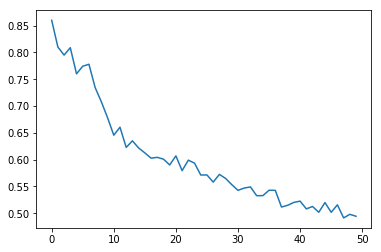

In [19]:
plt.plot(test_accuracies)
# plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()